# EOF of 
- [ ] SST
- [ ] LCC
- [ ] TCC
- [ ] SSH
- [ ] EKE
- [ ] Winds
- [ ] SW/LW/SH/LH

## Load in data and resample ERA5 vars to daily, and ERA5 heat fluxes to W/m$^2$

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from eofs.xarray import Eof as eof
import xeofs as xe

In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc', chunks={})
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc', chunks={})
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc', chunks={})
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc', chunks={})

heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})

glorys = xr.open_dataset('glorys_vars.nc', chunks={})

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
heat_fluxes

<xarray.Dataset> Size: 1GB
Dimensions:    (longitude: 69, latitude: 55, time: 10408)
Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [4]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = gom = dict(longitude=slice(-98,-81), latitude=slice(17.5,31))

sst = sst_ds.sea_surface_temperature.sel(**time_slice).resample(time="1D").mean()
tcc = tcc_ds.total_cloud_cover.sel(**time_slice).resample(time="1D").mean()
mslp = mslp_ds.mean_sea_level_pressure.sel(**time_slice).resample(time="1D").mean()
u10 = u10_ds['10m_u_component_of_wind'].sel(**time_slice).resample(time="1D").mean()
v10 = v10_ds['10m_v_component_of_wind'].sel(**time_slice).resample(time="1D").mean()
mask = mask_ds.land_sea_mask
lcc = lcc_ds.lcc.sel(**time_slice).resample(time="1D").mean()

sw = heat_fluxes.ssr / (60*60) #W/m2
lw = heat_fluxes.str / (60*60) #W/m2
sh = heat_fluxes.sshf / (60*60) #W/m2
lh = heat_fluxes.slhf / (60*60) #W/m2

sst_g = glorys.thetao.chunk({'time':1301}).sel(**gom).isel(depth=0).drop_vars('depth')
ssh = glorys.chunk({'time':1301}).zos.sel(**gom)
u = glorys.chunk({'time':1301}).uo.sel(**gom).isel(depth=0).drop_vars('depth')
v = glorys.chunk({'time':1301}).vo.sel(**gom).isel(depth=0).drop_vars('depth')
eke = 0.5 * (u**2 + v**2)

## Calculate EOFs
(and save them to netcdf)

In [5]:
def xeof_func(da):
    # this sets up the solver
    eof = xe.single.EOF(n_modes=3)
    eofs = eof.fit(da, dim='time')
    
    comps = eof.components()  # EOFs (spatial patterns)
    scores = eof.scores()  # PCs (temporal patterns)
    variance = eof.explained_variance_ratio() #variance ratio
    
    return comps, scores, variance

In [6]:
sst_eof = xeof_func(sst)
tcc_eof = xeof_func(tcc)
mslp_eof = xeof_func(mslp)
u10_eof = xeof_func(u10)
v10_eof = xeof_func(v10)
lcc_eof = xeof_func(lcc)

sw_eof = xeof_func(sw)
lw_eof = xeof_func(lw)
sh_eof = xeof_func(sh)
lh_eof = xeof_func(lh)

In [7]:
sst_g_eof = xeof_func(sst_g)
ssh_eof = xeof_func(ssh)
u_eof = xeof_func(u)
v_eof = xeof_func(v)
eke_eof = xeof_func(eke)

In [16]:
sst_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_eofs.nc')
sst_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_var_frac.nc')
sst_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_pcs.nc')

In [17]:
tcc_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/tcc_eofs.nc')
tcc_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/tcc_var_frac.nc')
tcc_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/tcc_pcs.nc')

In [18]:
lcc_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lcc_eofs.nc')
lcc_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lcc_var_frac.nc')
lcc_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lcc_pcs.nc')

In [19]:
mslp_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/mslp_eofs.nc')
mslp_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/mslp_var_frac.nc')
mslp_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/mslp_pcs.nc')

In [20]:
u10_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u10_eofs.nc')
u10_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u10_var_frac.nc')
u10_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u10_pcs.nc')

In [21]:
v10_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v10_eofs.nc')
v10_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v10_var_frac.nc')
v10_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v10_pcs.nc')

In [22]:
sw_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sw_eofs.nc')
sw_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sw_var_frac.nc')
sw_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sw_pcs.nc')

In [23]:
lw_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lw_eofs.nc')
lw_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lw_var_frac.nc')
lw_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lw_pcs.nc')

In [24]:
sh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sh_eofs.nc')
sh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sh_var_frac.nc')
sh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sh_pcs.nc')

In [25]:
lh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lh_eofs.nc')
lh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lh_var_frac.nc')
lh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/lh_pcs.nc')

In [26]:
sst_g_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_eofs.nc')
sst_g_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_var_frac.nc')
sst_g_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_pcs.nc')

In [27]:
ssh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_eofs.nc')
ssh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_var_frac.nc')
ssh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_pcs.nc')

In [28]:
u_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u_eofs.nc')
u_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u_var_frac.nc')
u_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/u_pcs.nc')

In [29]:
v_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v_eofs.nc')
v_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v_var_frac.nc')
v_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/v_pcs.nc')

In [30]:
eke_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_eofs.nc')
eke_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_var_frac.nc')
eke_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_pcs.nc')

## Plot EOFs/PCs

In [54]:
def open_ds(filename, vartype=None):
    if vartype=='pcs':
        ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/{filename}_pcs.nc', chunks={})
    elif vartype=='var_frac':
        ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/{filename}_var_frac.nc', chunks={})
    else:
        ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/{filename}_eofs.nc', chunks={})
    return ds

In [55]:
sst_eof = open_ds('sst')
sst_frac = open_ds('sst', 'var_frac')
sst_pcs = open_ds('sst', 'pcs')
tcc_eof = open_ds('tcc')
tcc_frac = open_ds('tcc', 'var_frac')
tcc_pcs = open_ds('tcc', 'pcs')
mslp_eof = open_ds('mslp')
mslp_frac = open_ds('mslp', 'var_frac')
mslp_pcs = open_ds('mslp', 'pcs')
u10_eof = open_ds('u10')
u10_frac = open_ds('u10', 'var_frac')
u10_pcs = open_ds('u10', 'pcs')
v10_eof = open_ds('v10')
v10_frac = open_ds('v10', 'var_frac')
v10_pcs = open_ds('v10', 'pcs')
lcc_eof = open_ds('lcc')
lcc_frac = open_ds('lcc', 'var_frac')
lcc_pcs = open_ds('lcc', 'pcs')

sw_eof = open_ds('sw')
sw_frac = open_ds('sw', 'var_frac')
sw_pcs = open_ds('sw', 'pcs')
lw_eof = open_ds('lw')
lw_frac = open_ds('lw', 'var_frac')
lw_pcs = open_ds('lw', 'pcs')
sh_eof = open_ds('sh')
sh_frac = open_ds('sh', 'var_frac')
sh_pcs = open_ds('sh', 'pcs')
lh_eof = open_ds('lh')
lh_frac = open_ds('lh', 'var_frac')
lh_pcs = open_ds('lh', 'pcs')

In [56]:
sst_g_eof = open_ds('sst_g')
sst_g_frac = open_ds('sst_g', 'var_frac')
sst_g_pcs = open_ds('sst_g', 'pcs')
ssh_eof = open_ds('ssh')
ssh_frac = open_ds('ssh', 'var_frac')
ssh_pcs = open_ds('ssh', 'pcs')
u_eof = open_ds('u')
u_frac = open_ds('u', 'var_frac')
u_pcs = open_ds('u', 'pcs')
v_eof = open_ds('v')
v_frac = open_ds('v', 'var_frac')
v_pcs = open_ds('v', 'pcs')
eke_eof = open_ds('eke')
eke_frac = open_ds('eke', 'var_frac')
eke_pcs = open_ds('eke', 'pcs')

In [57]:
sst_eof

<xarray.Dataset> Size: 92kB
Dimensions:     (latitude: 55, longitude: 69, mode: 3)
Coordinates:
  * latitude    (latitude) float32 220B 17.5 17.75 18.0 ... 30.5 30.75 31.0
  * longitude   (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * mode        (mode) int64 24B 1 2 3
Data variables:
    components  (mode, latitude, longitude) float64 91kB dask.array<chunksize=(3, 55, 69), meta=np.ndarray>

### ERA5 vars

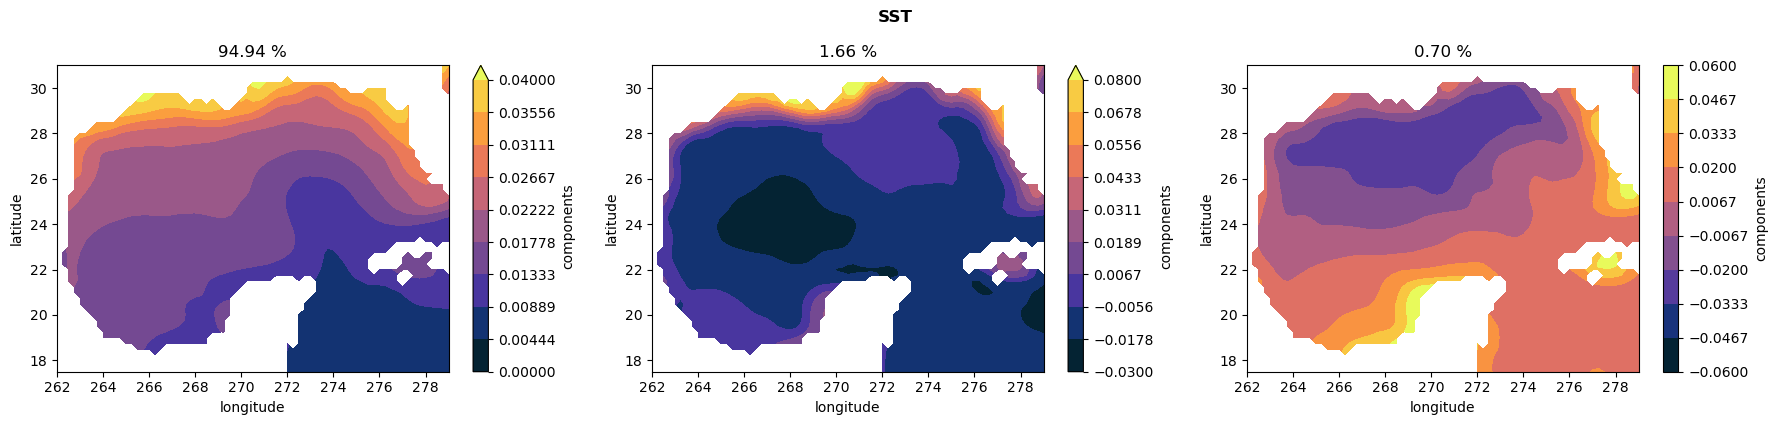

In [66]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(0, 0.04, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_frac.explained_variance_ratio[0].values*100:.2f} %')

sst_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.03, 0.08, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_frac.explained_variance_ratio[1].values*100:.2f} %')

sst_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.06, .06, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_frac.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('SST', fontweight='bold', y=1.05);

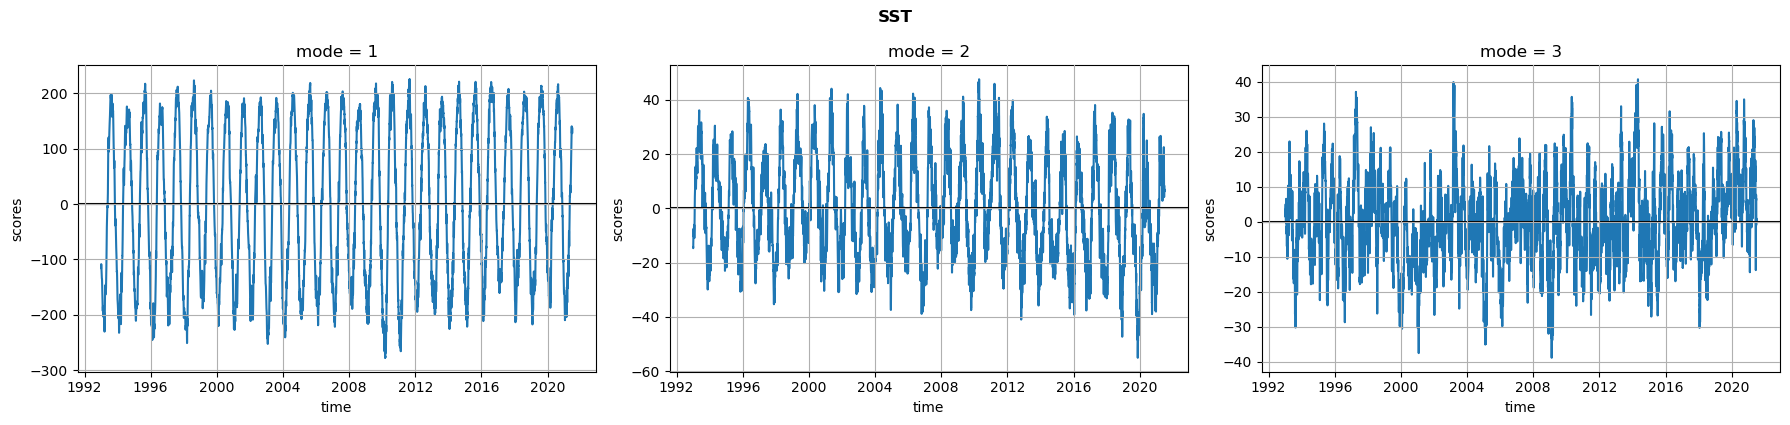

In [70]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sst_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sst_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SST', fontweight='bold', y=1.05);

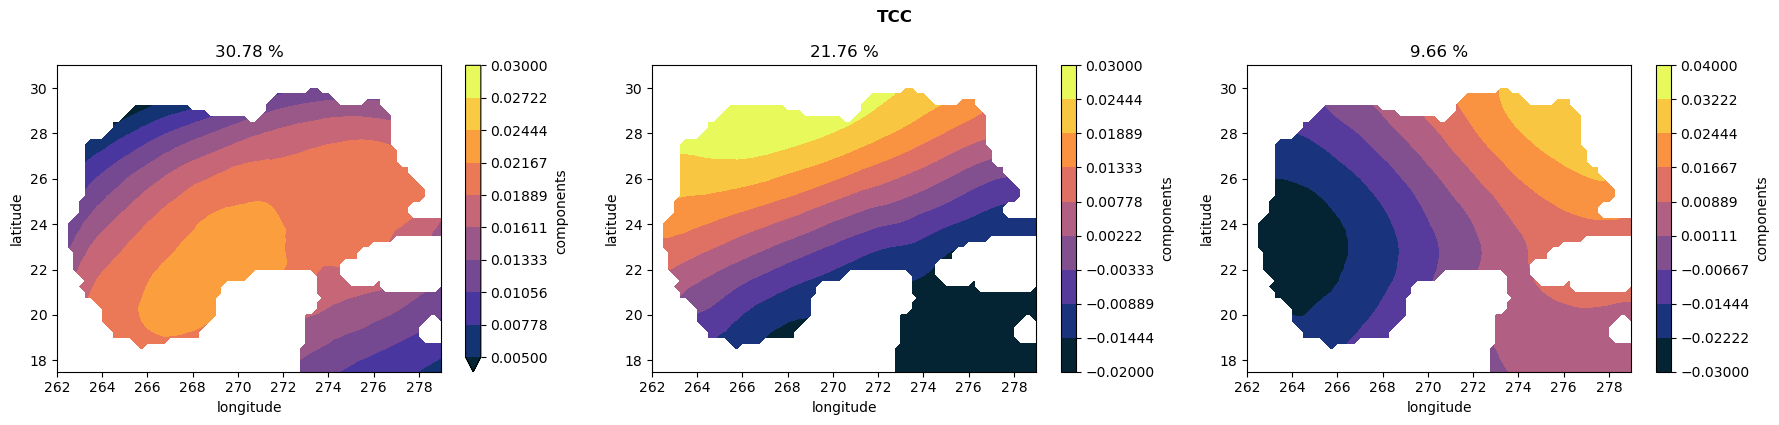

In [74]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

tcc_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.005, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{tcc_frac.explained_variance_ratio[0].values*100:.2f} %')

tcc_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.02, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{tcc_frac.explained_variance_ratio[1].values*100:.2f} %')

tcc_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{tcc_frac.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('TCC', fontweight='bold', y=1.05);

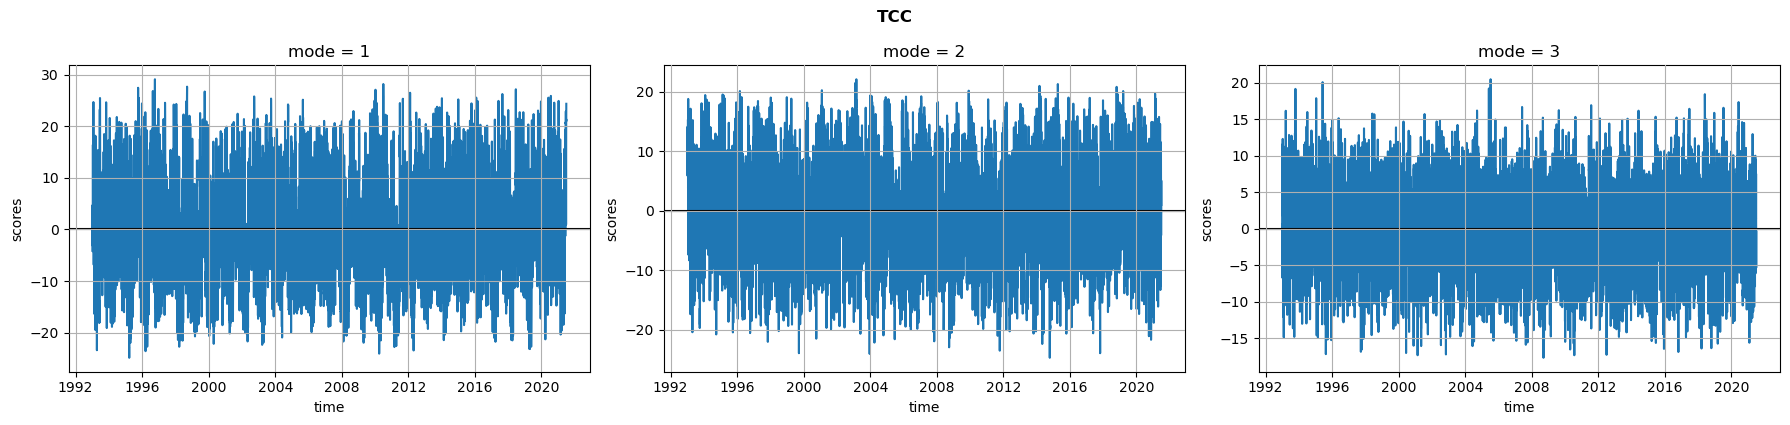

In [75]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
tcc_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

tcc_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

tcc_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('TCC', fontweight='bold', y=1.05);

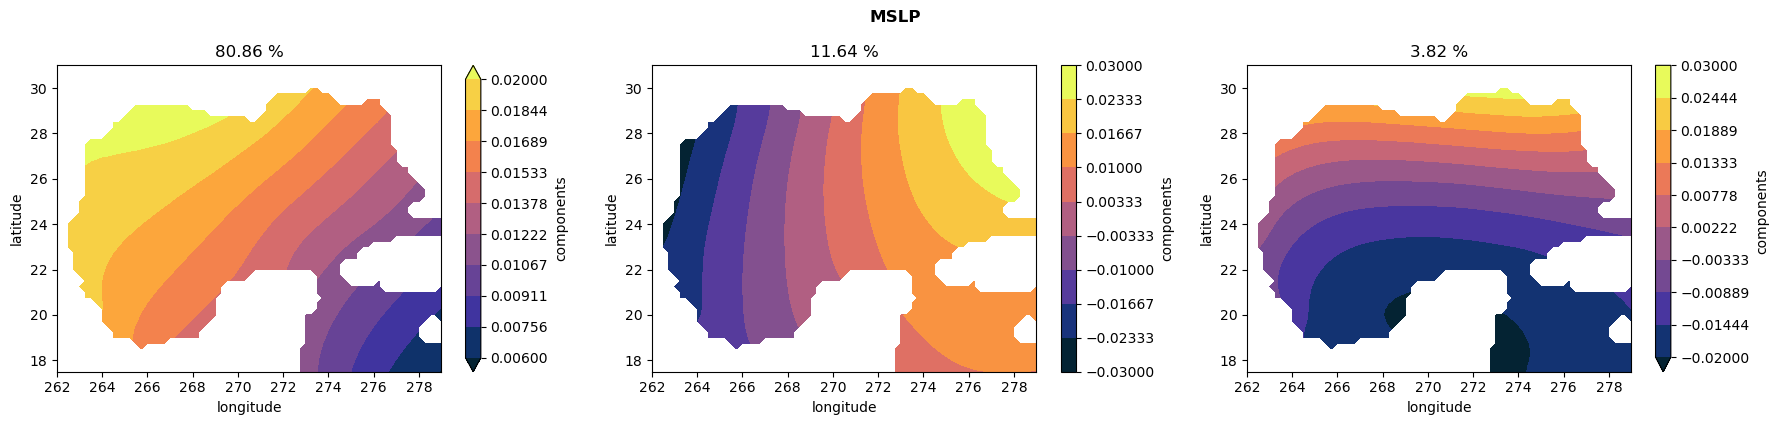

In [83]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
mslp_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.006, .02, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{mslp_frac.explained_variance_ratio[0].values*100:.2f} %')
mslp_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{mslp_frac.explained_variance_ratio[1].values*100:.2f} %')
mslp_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.02, .03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{mslp_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('MSLP', fontweight='bold', y=1.05);

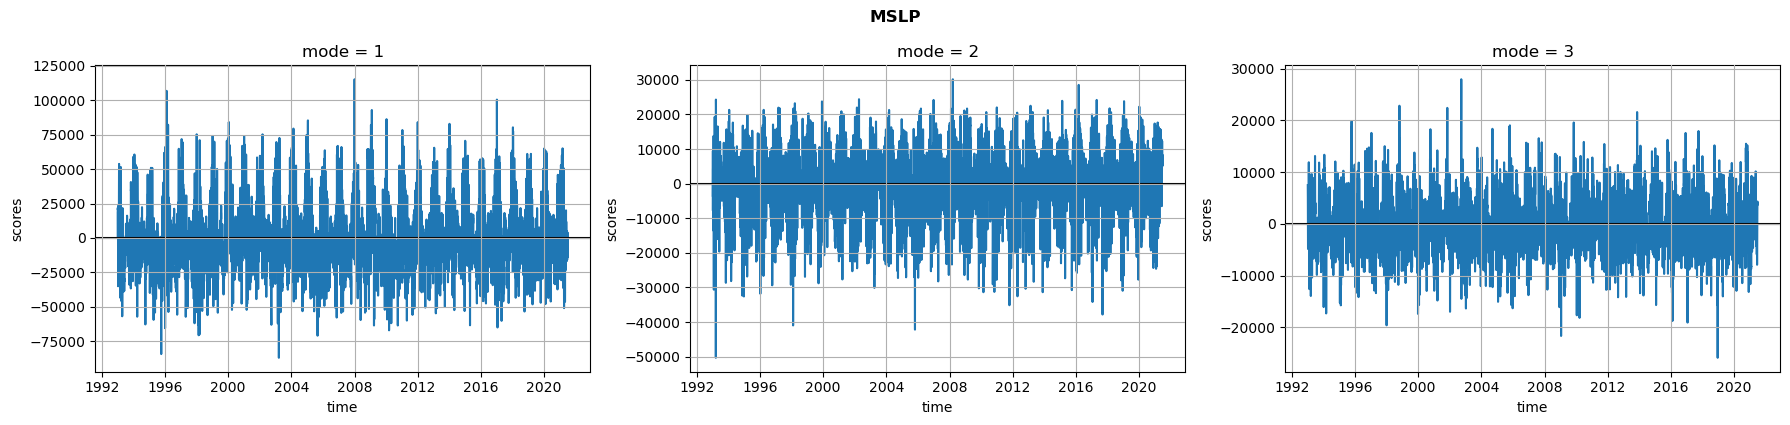

In [84]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
mslp_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

mslp_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

mslp_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('MSLP', fontweight='bold', y=1.05);

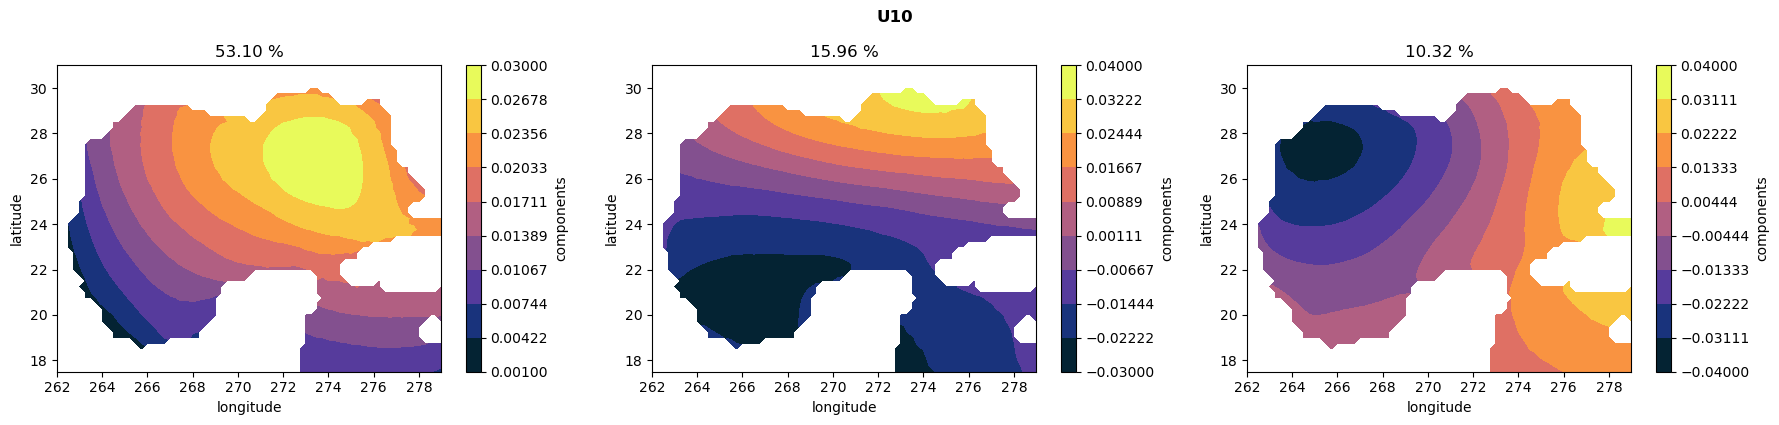

In [88]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.001, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{u10_frac.explained_variance_ratio[0].values*100:.2f} %')
u10_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{u10_frac.explained_variance_ratio[1].values*100:.2f} %')
u10_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{u10_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('U10', fontweight='bold', y=1.05);

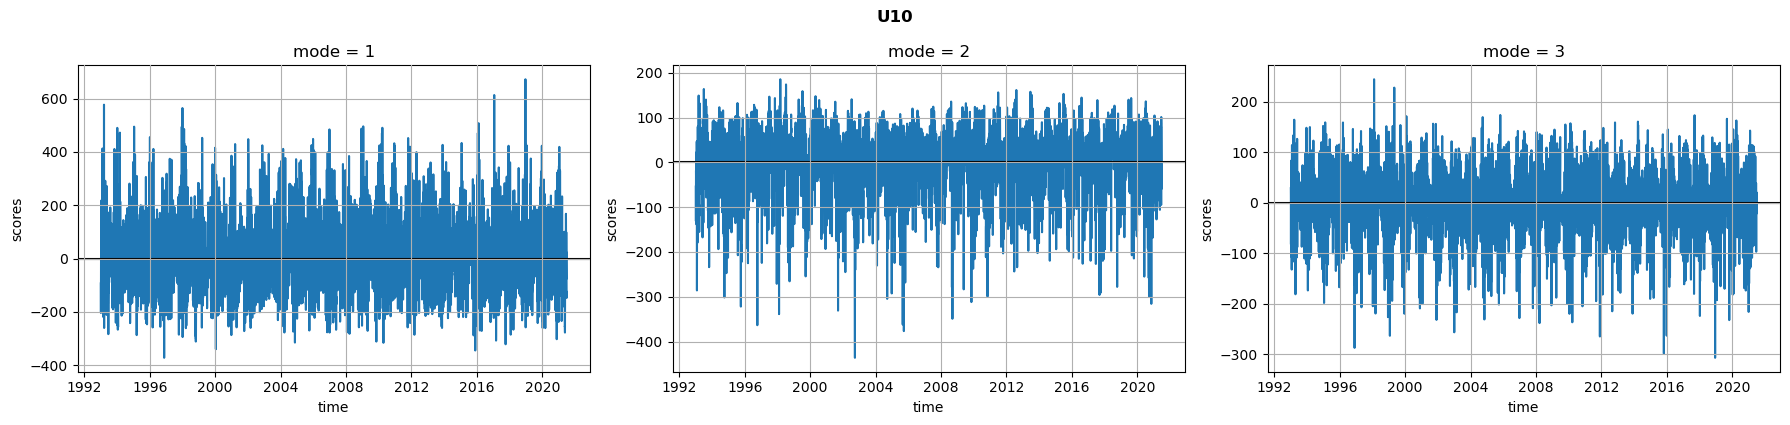

In [89]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

u10_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

u10_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('U10', fontweight='bold', y=1.05);

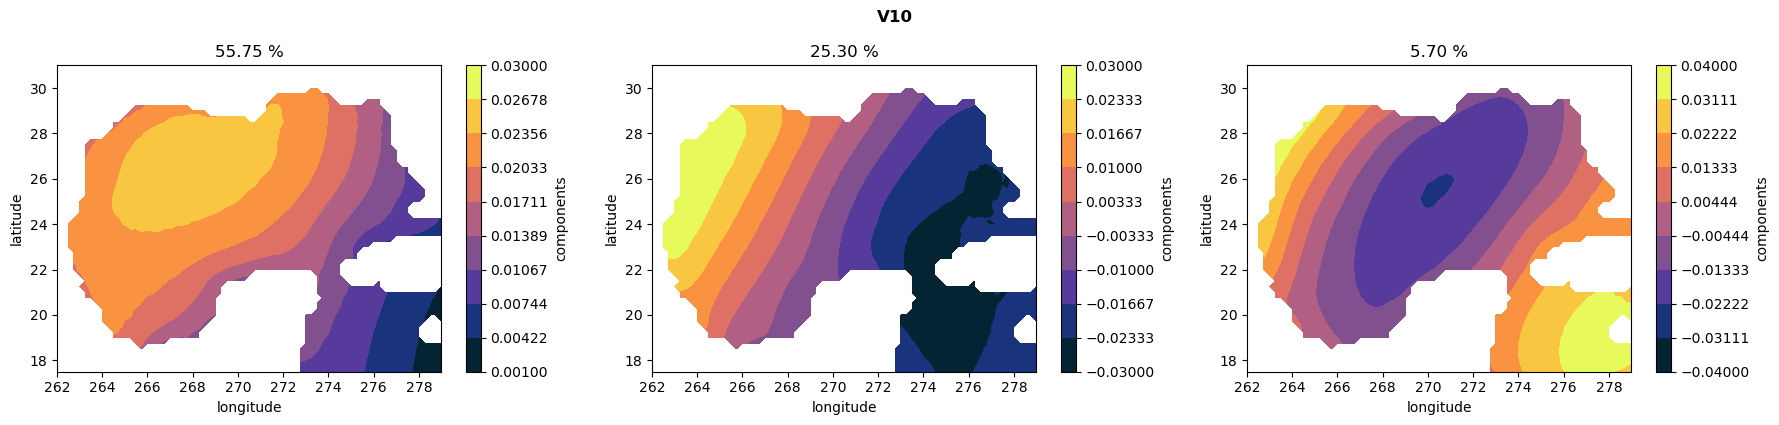

In [92]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.001, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_frac.explained_variance_ratio[0].values*100:.2f} %')
v10_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_frac.explained_variance_ratio[1].values*100:.2f} %')
v10_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('V10', fontweight='bold', y=1.05);

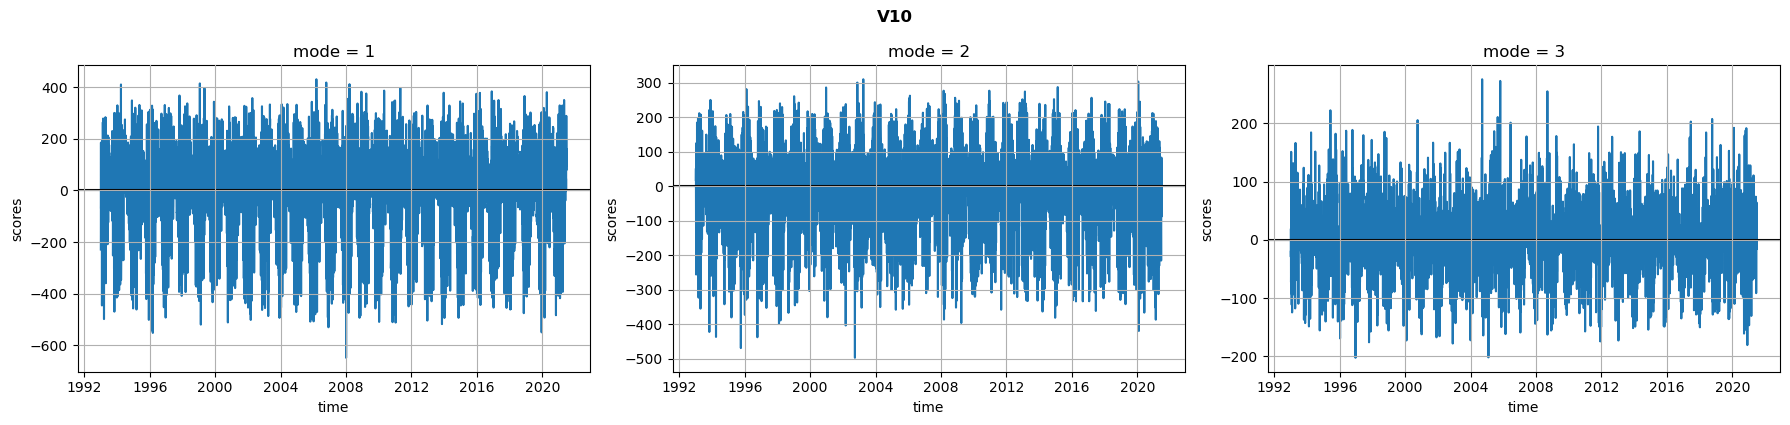

In [93]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

v10_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

v10_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('V10', fontweight='bold', y=1.05);

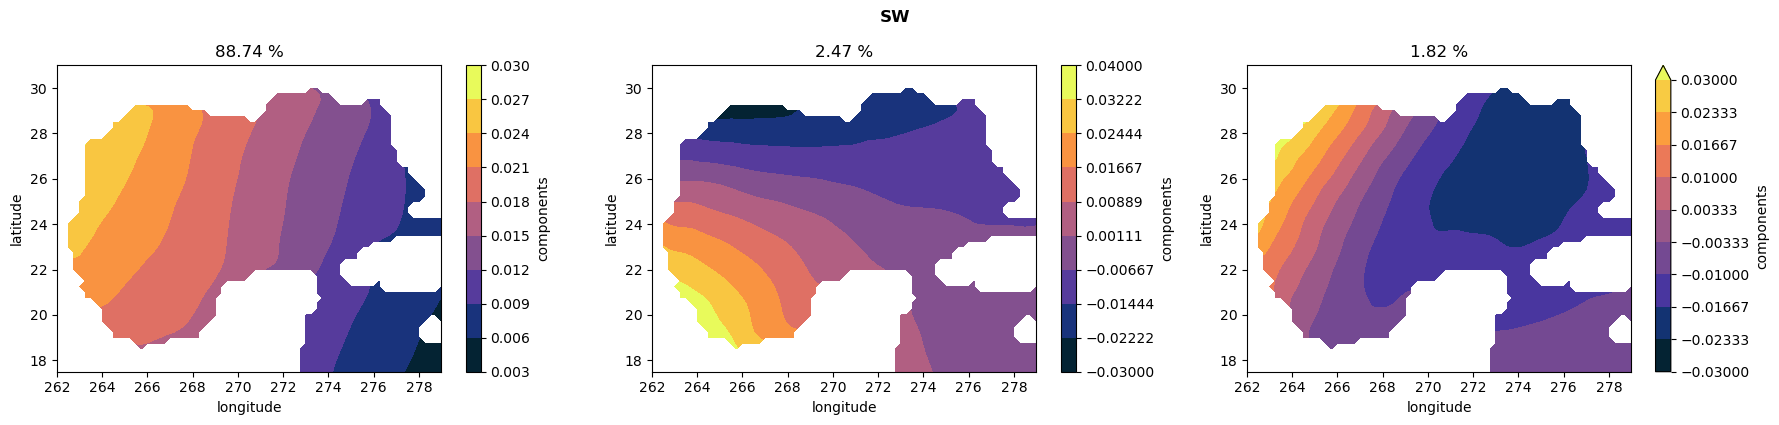

In [102]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sw_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.003, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sw_frac.explained_variance_ratio[0].values*100:.2f} %')
sw_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sw_frac.explained_variance_ratio[1].values*100:.2f} %')
sw_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sw_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('SW', fontweight='bold', y=1.05);

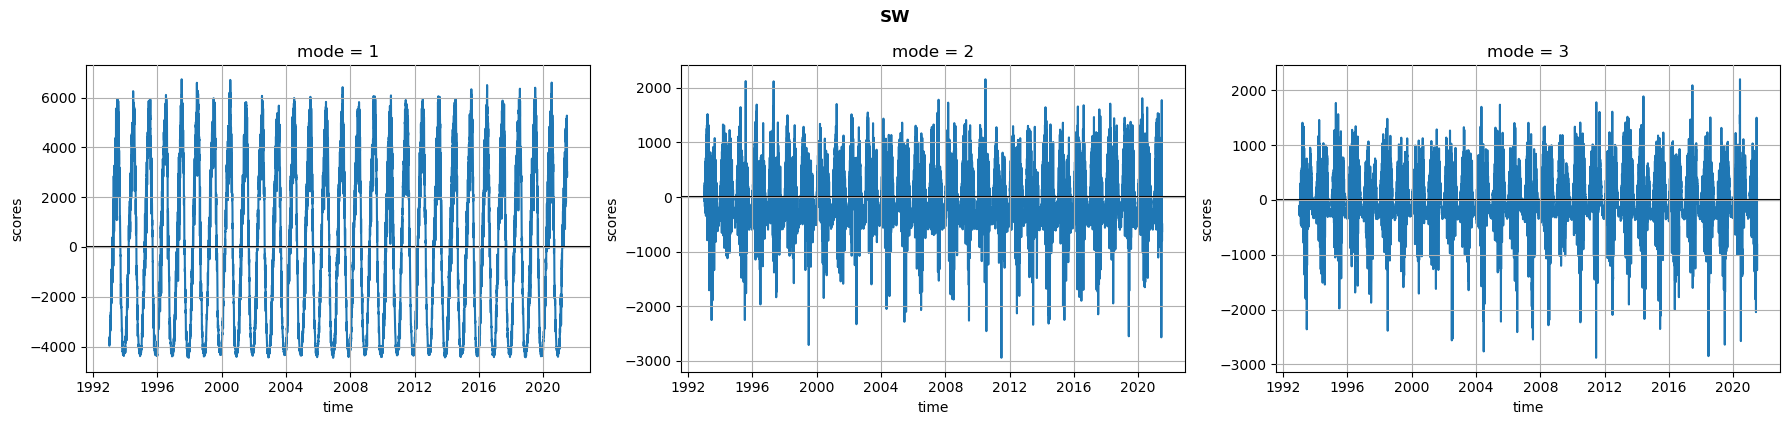

In [100]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sw_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sw_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sw_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SW', fontweight='bold', y=1.05);

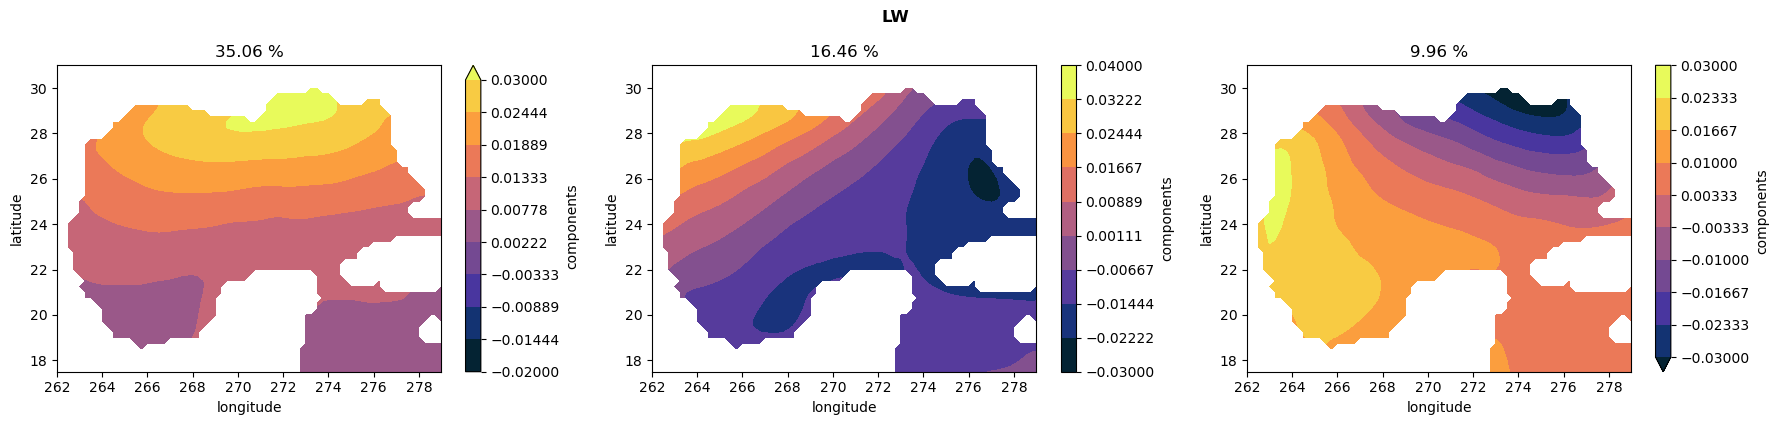

In [115]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lw_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.02, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{lw_frac.explained_variance_ratio[0].values*100:.2f} %')
lw_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{lw_frac.explained_variance_ratio[1].values*100:.2f} %')
lw_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{lw_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('LW', fontweight='bold', y=1.05);

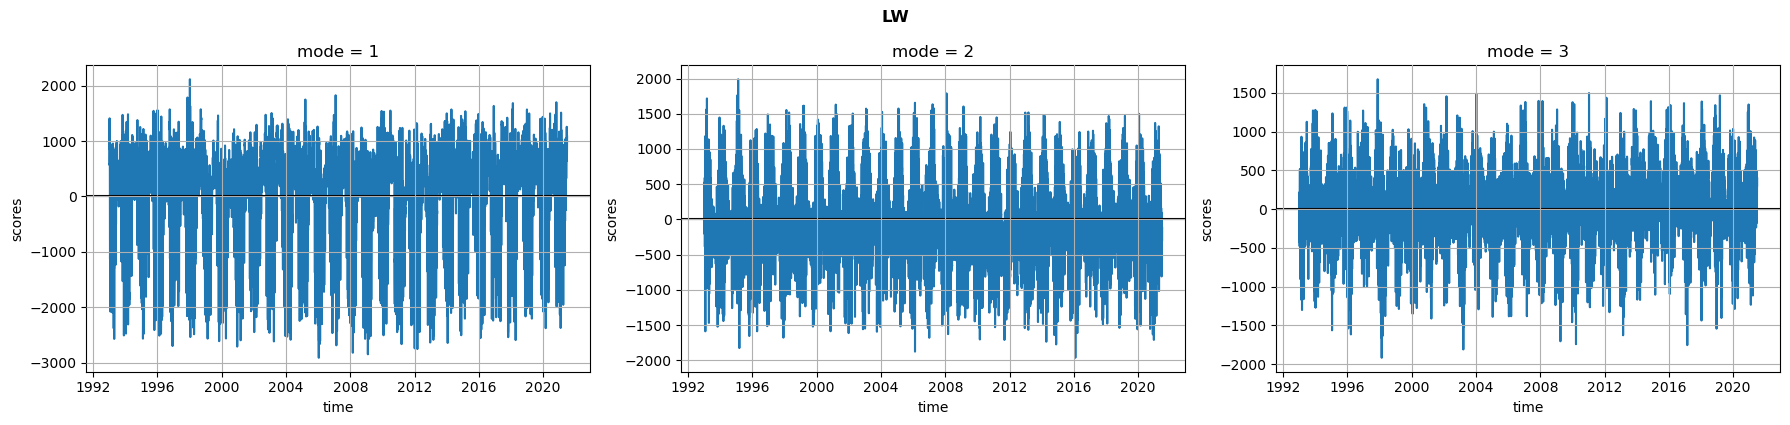

In [116]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lw_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

lw_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

lw_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('LW', fontweight='bold', y=1.05);

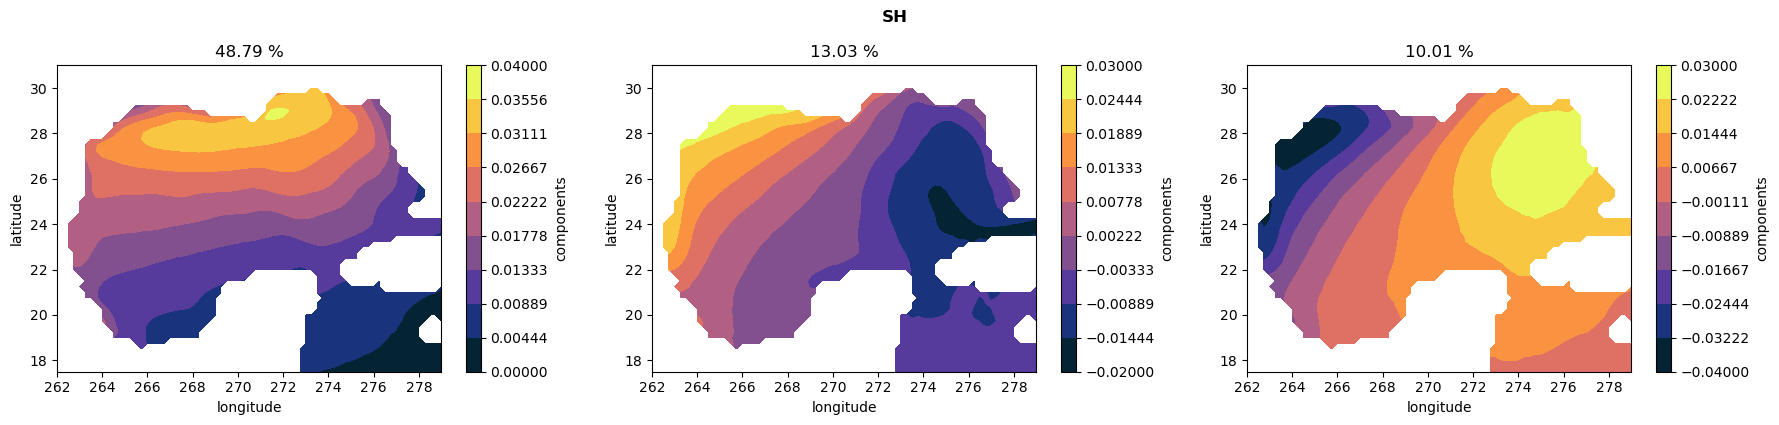

In [121]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sh_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.04, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sh_frac.explained_variance_ratio[0].values*100:.2f} %')
sh_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.02, 0.03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sh_frac.explained_variance_ratio[1].values*100:.2f} %')
sh_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sh_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('SH', fontweight='bold', y=1.05);

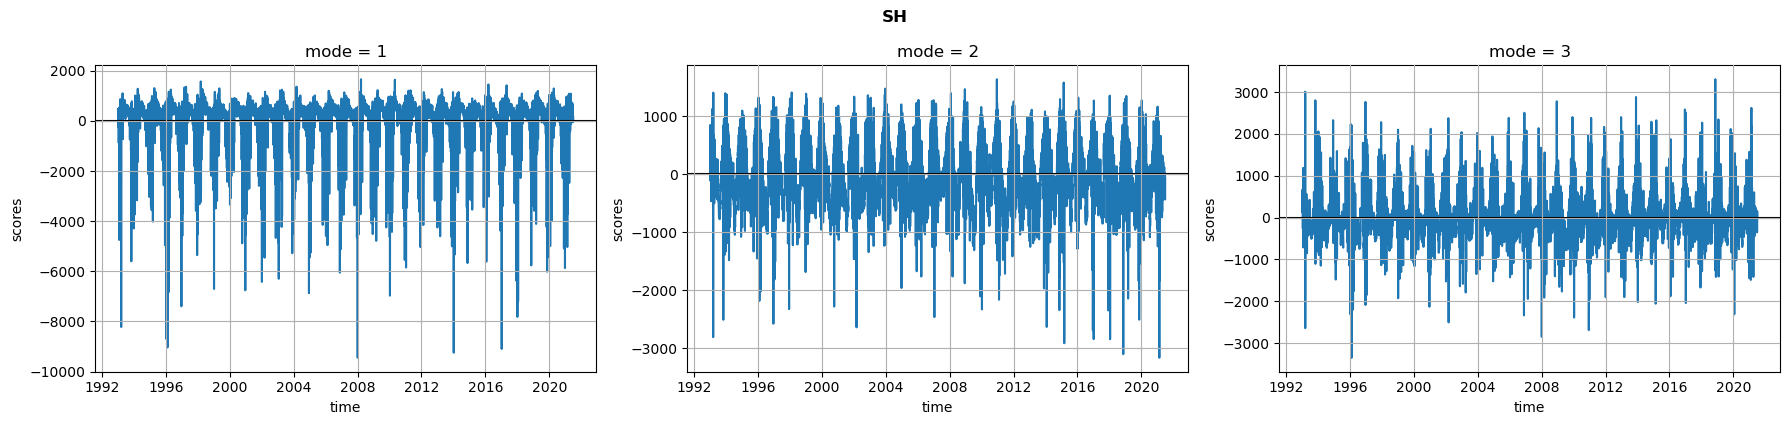

In [122]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sh_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sh_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sh_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SH', fontweight='bold', y=1.05);

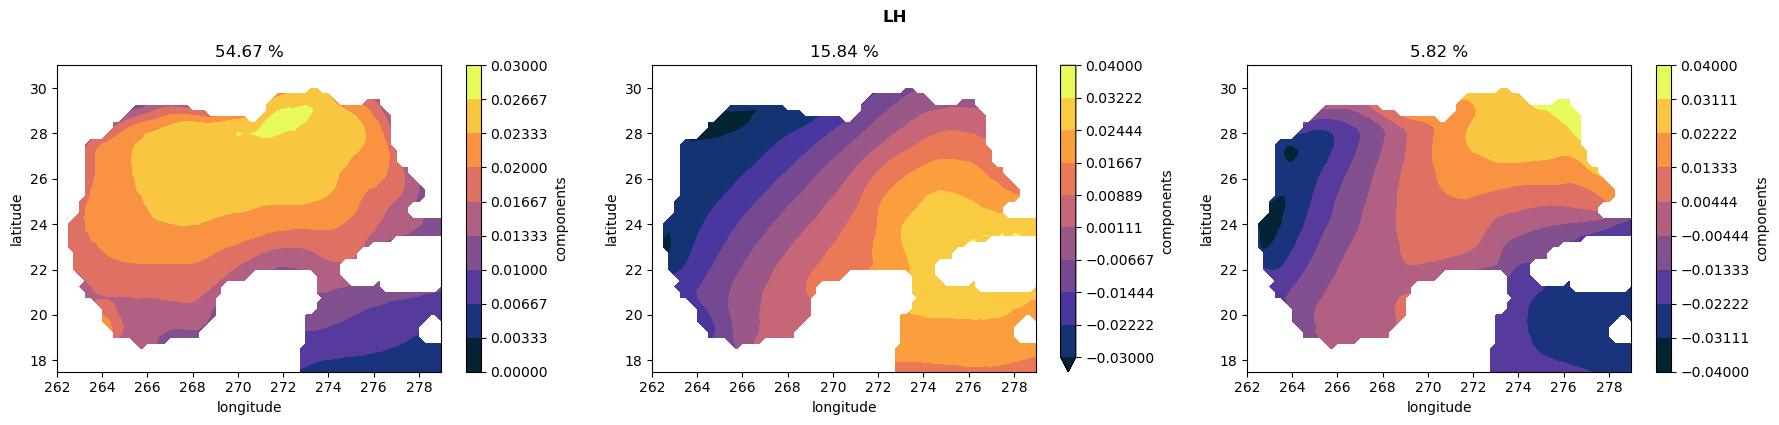

In [128]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lh_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{lh_frac.explained_variance_ratio[0].values*100:.2f} %')
lh_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{lh_frac.explained_variance_ratio[1].values*100:.2f} %')
lh_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{lh_frac.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('LH', fontweight='bold', y=1.05);

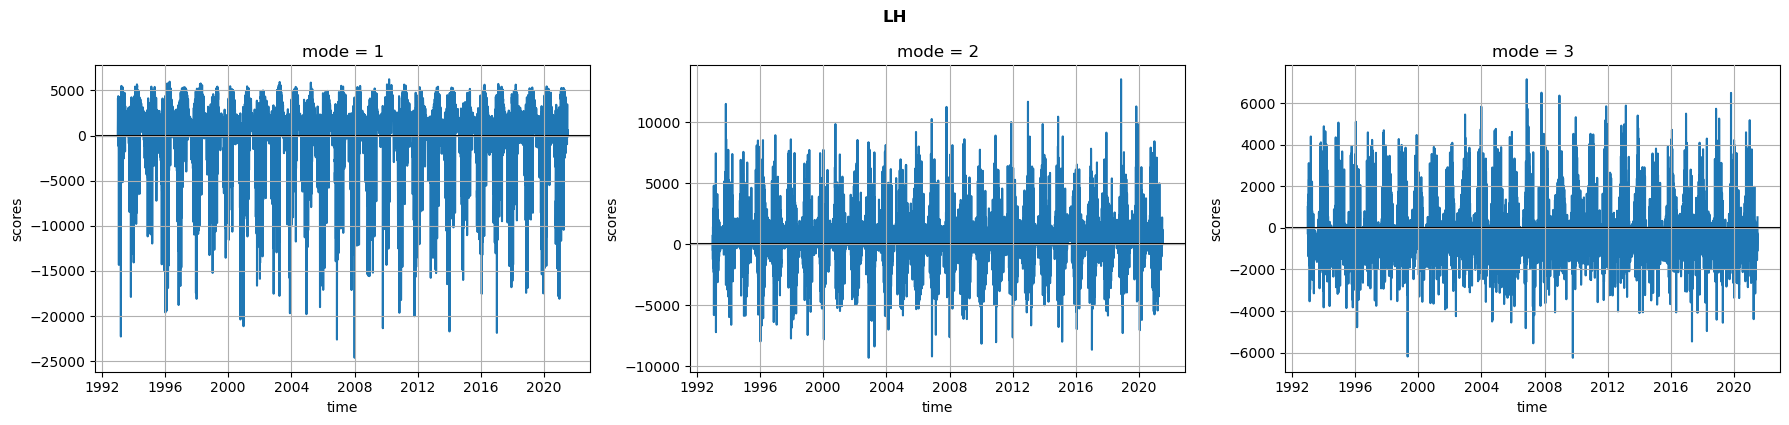

In [124]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lh_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

lh_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

lh_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('LH', fontweight='bold', y=1.05);

### GLORYS vars

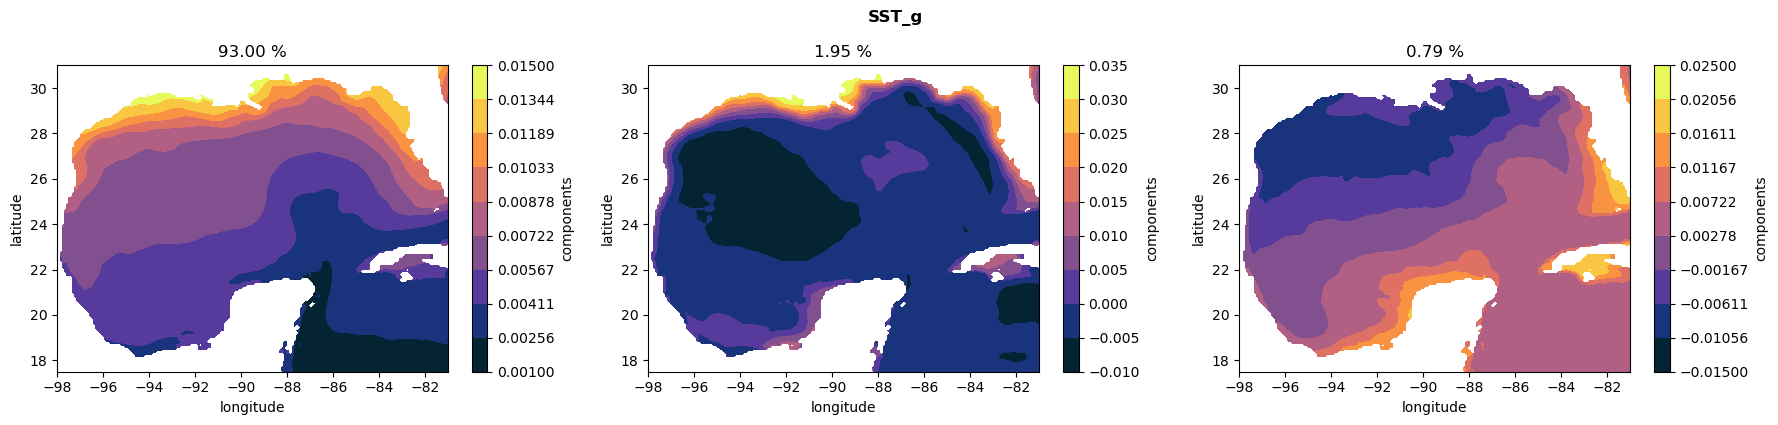

In [146]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_g_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(0.001, 0.015, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_g_frac.explained_variance_ratio[0].values*100:.2f} %')

sst_g_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.01, .035, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_g_frac.explained_variance_ratio[1].values*100:.2f} %')

sst_g_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.015, .025, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_g_frac.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('SST_g', fontweight='bold', y=1.05);

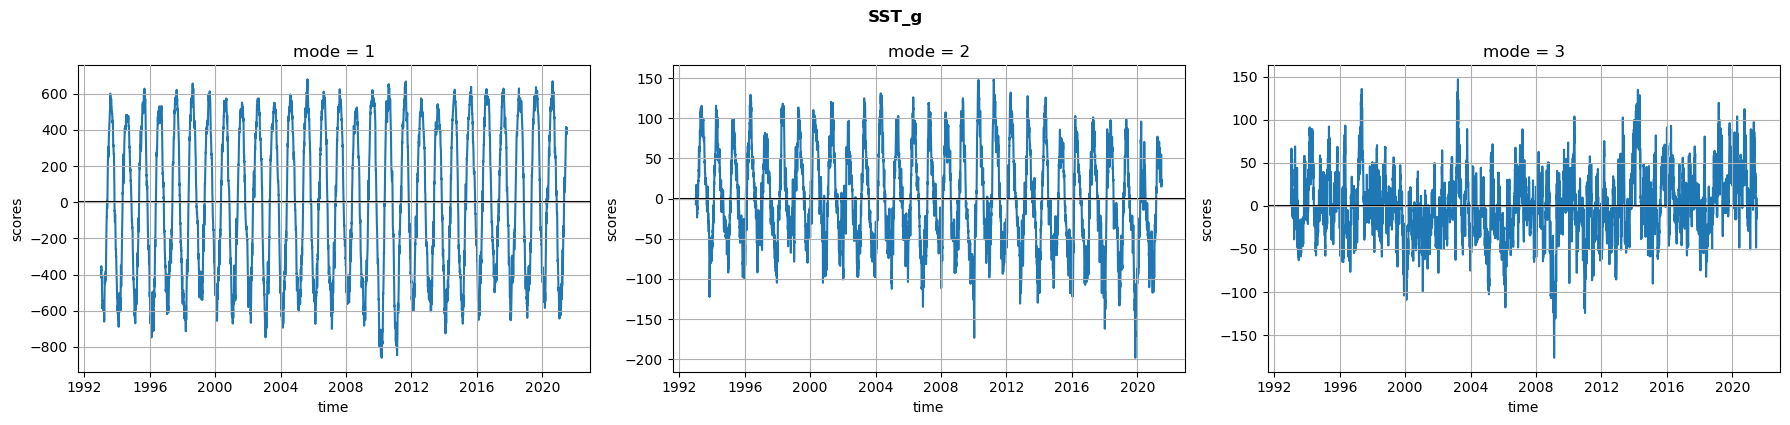

In [147]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_g_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sst_g_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sst_g_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SST_g', fontweight='bold', y=1.05);

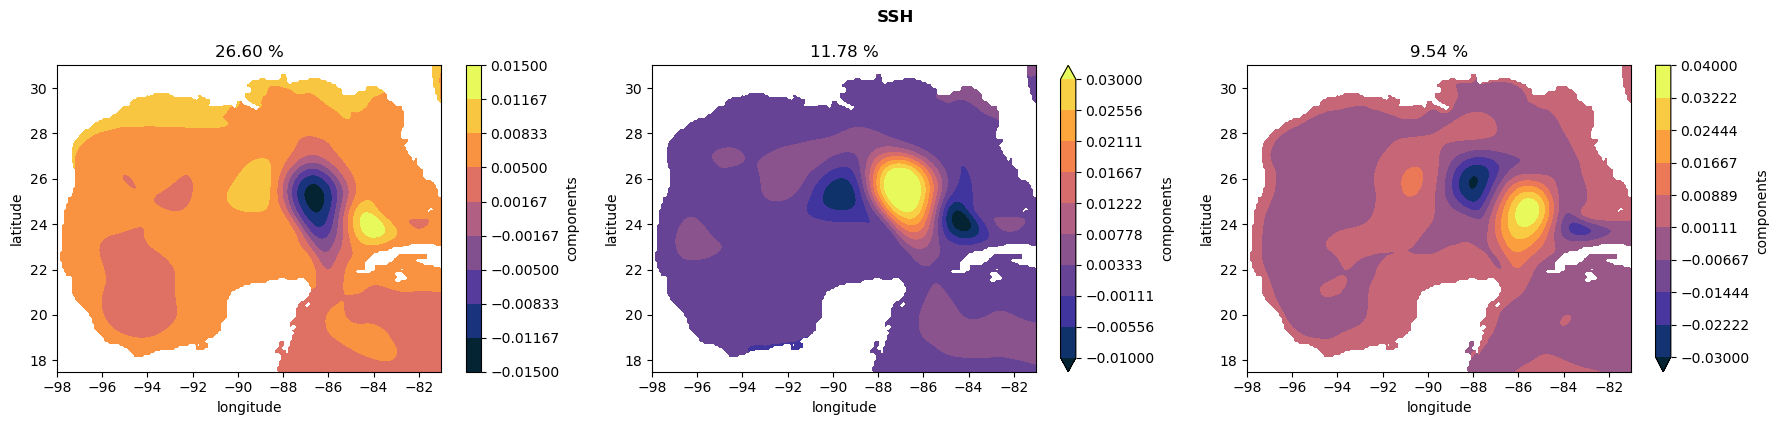

In [157]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ssh_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.015, 0.015, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{ssh_frac.explained_variance_ratio[0].values*100:.2f} %')

ssh_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.01, .03, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{ssh_frac.explained_variance_ratio[1].values*100:.2f} %')

ssh_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{ssh_frac.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('SSH', fontweight='bold', y=1.05);

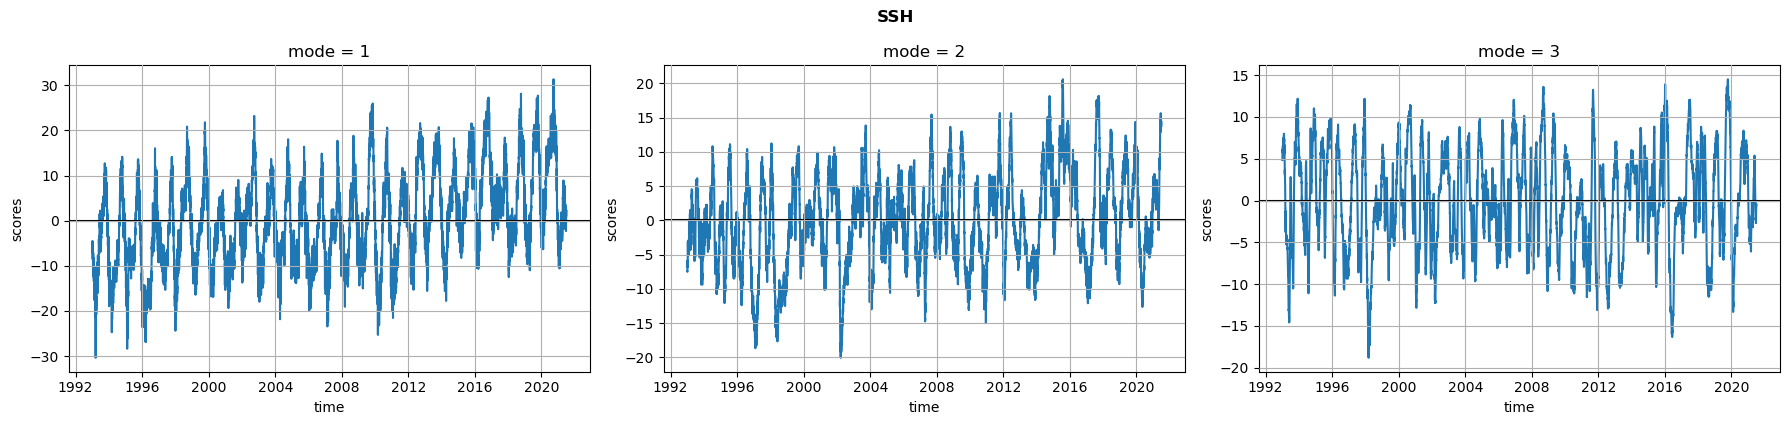

In [158]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ssh_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

ssh_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

ssh_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SSH', fontweight='bold', y=1.05);

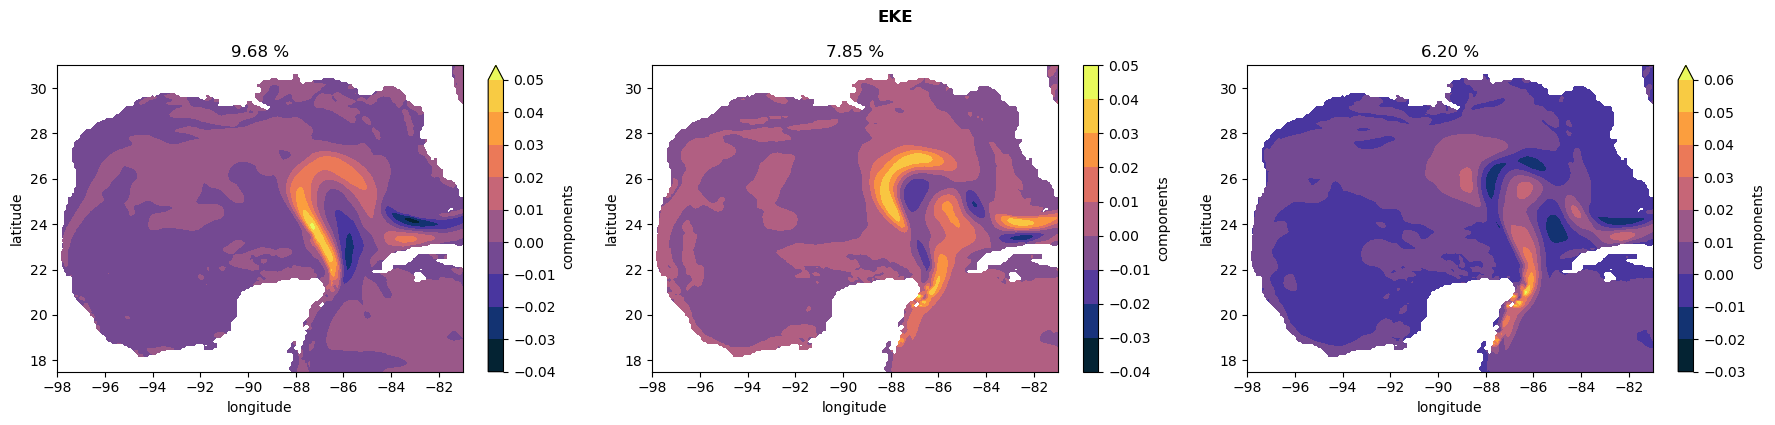

In [166]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
eke_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.04, 0.05, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{eke_frac.explained_variance_ratio[0].values*100:.2f} %')

eke_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.04, .05, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{eke_frac.explained_variance_ratio[1].values*100:.2f} %')

eke_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .06, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{eke_frac.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('EKE', fontweight='bold', y=1.05);

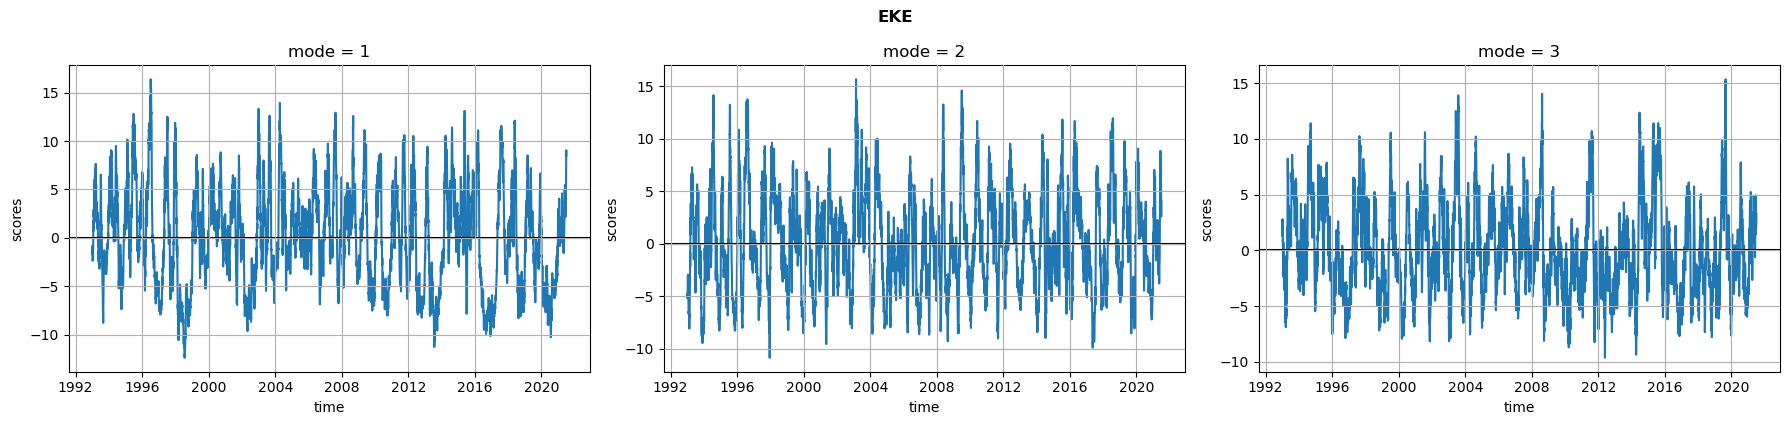

In [167]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
eke_pcs.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

eke_pcs.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

eke_pcs.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('EKE', fontweight='bold', y=1.05);

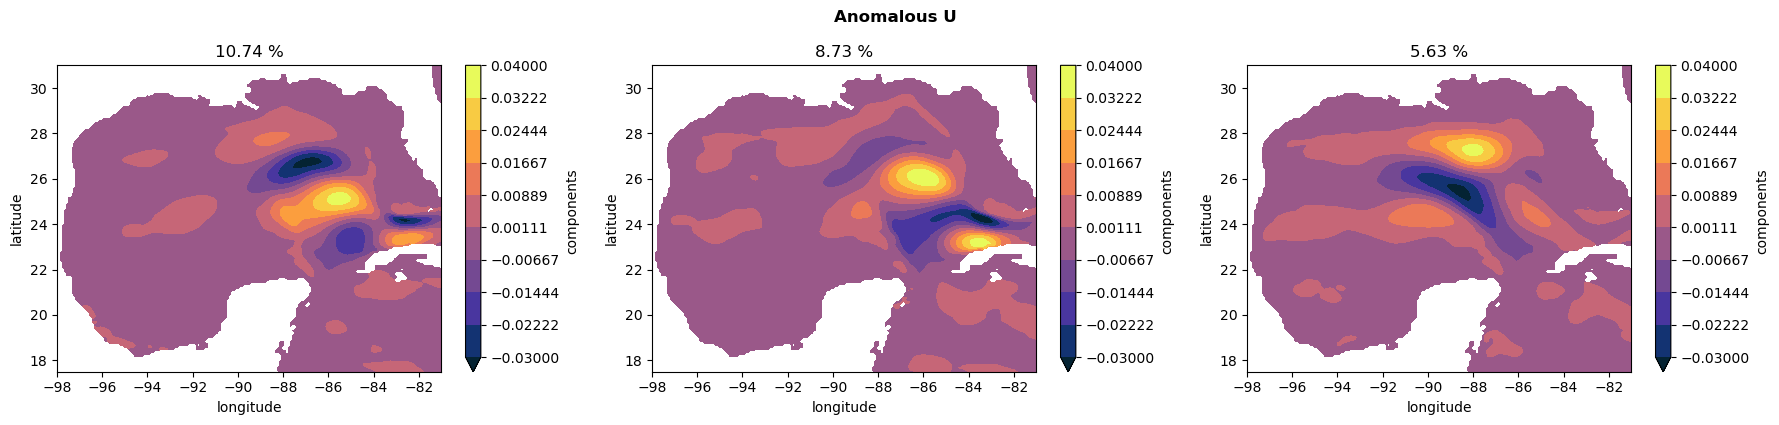

In [50]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0.04, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{u_eof.explained_variance_ratio[0].values*100:.2f} %')

u_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{u_eof.explained_variance_ratio[1].values*100:.2f} %')

u_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{u_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous U', fontweight='bold', y=1.05);

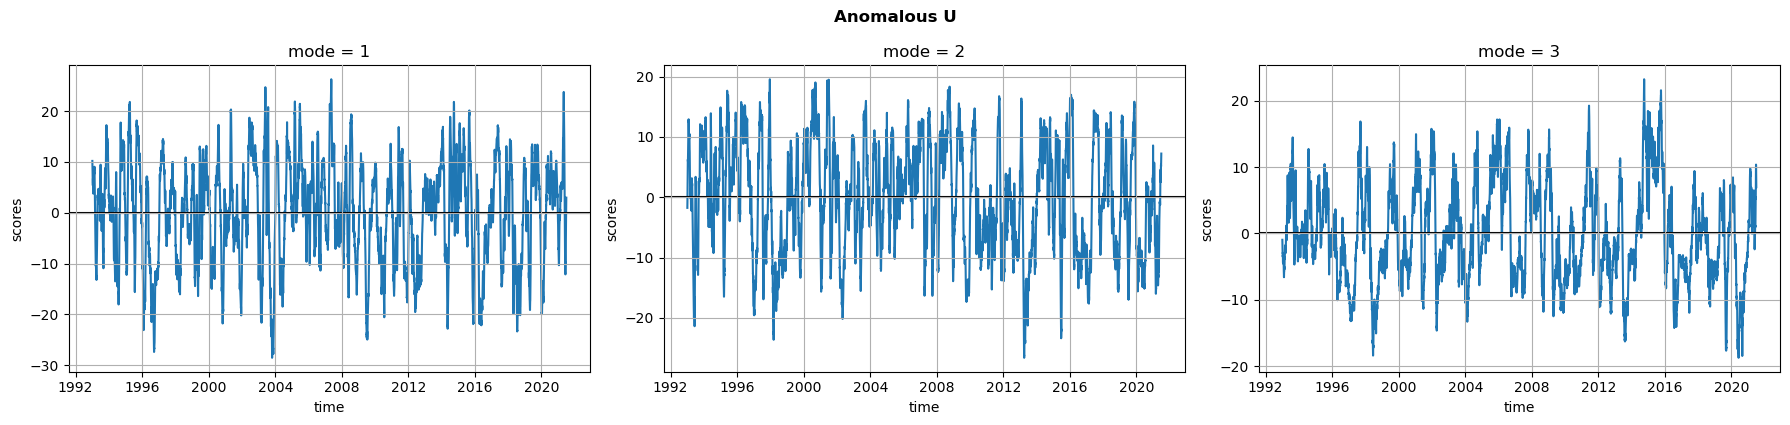

In [45]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

u_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

u_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous U', fontweight='bold', y=1.05);

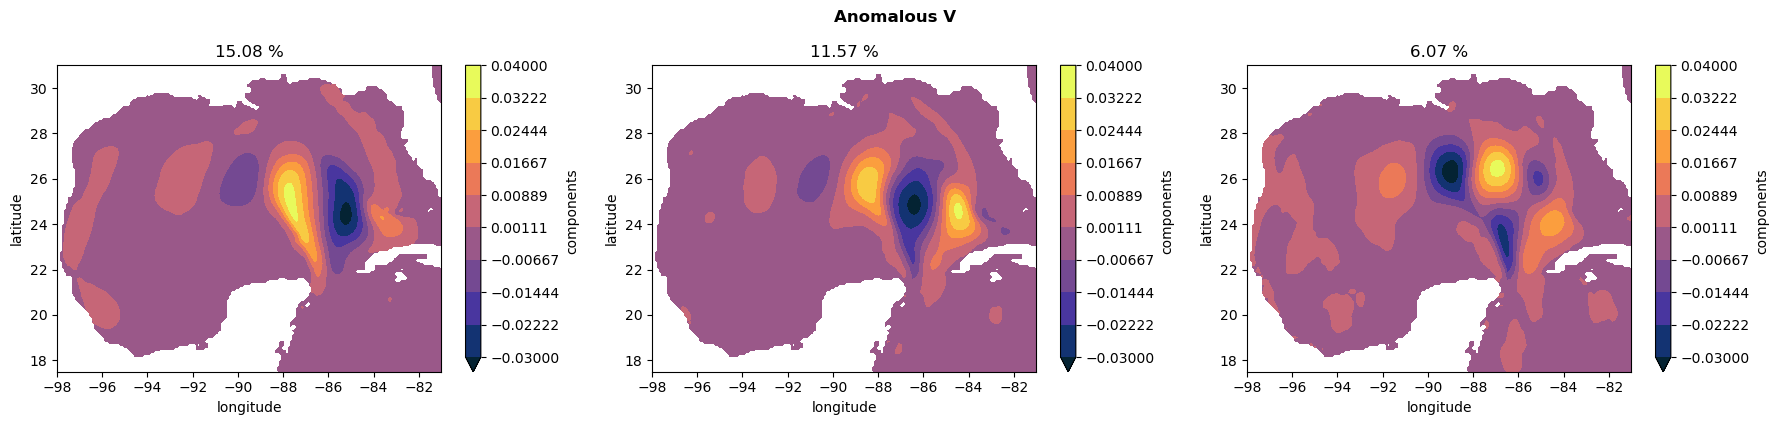

In [53]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0.04, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v_eof.explained_variance_ratio[0].values*100:.2f} %')

v_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v_eof.explained_variance_ratio[1].values*100:.2f} %')

v_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous V', fontweight='bold', y=1.05);

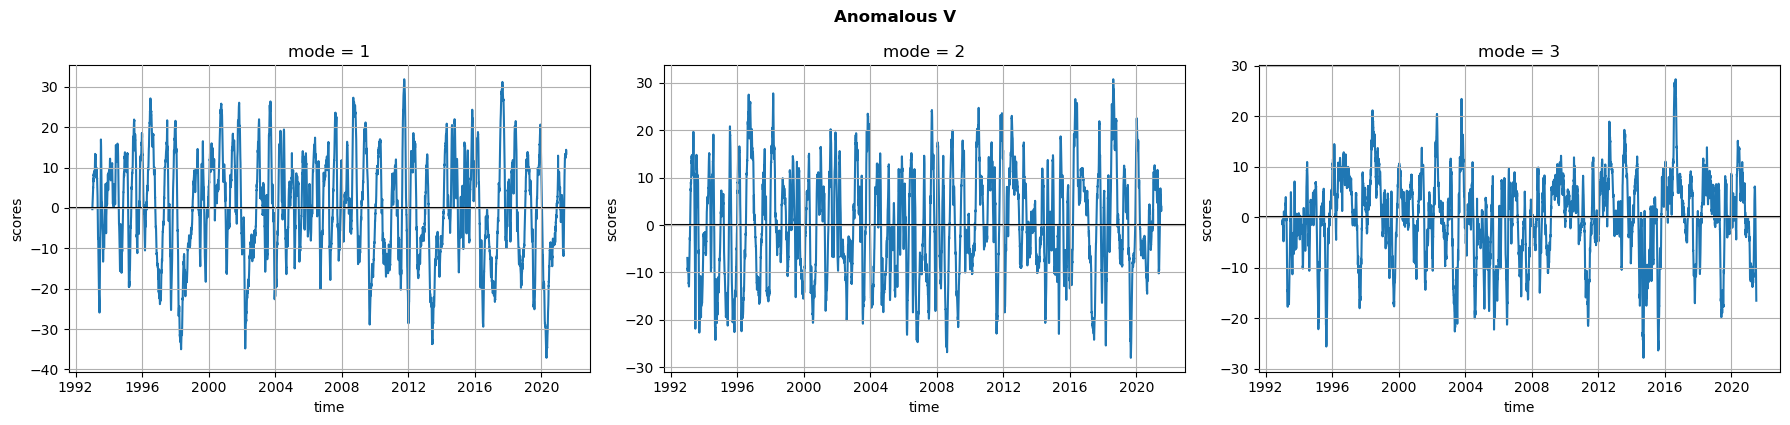

In [52]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

v_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

v_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous V', fontweight='bold', y=1.05);

## Calculate EOFs for anomalous vars
(and save them to netcdf)

In [2]:
#ssh,eke,u,v,sst_g are from GLORYS

sst = xr.open_dataarray('/work5/stb/ERA5/anom-fields/sst_anom.nc', chunks={})
tcc = xr.open_dataarray('/work5/stb/ERA5/anom-fields/tcc_anom.nc', chunks={})
mslp = xr.open_dataarray('/work5/stb/ERA5/anom-fields/mslp_anom.nc', chunks={})
u10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/u10_anom.nc', chunks={})
v10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/v10_anom.nc', chunks={})
mask = xr.open_dataarray('/work5/stb/ERA5/mask.nc', chunks={})
lcc = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lcc_anom.nc', chunks={})

sw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sw_anom.nc', chunks={})
lw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lw_anom.nc', chunks={})
sh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sh_anom.nc', chunks={})
lh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lh_anom.nc', chunks={})

ssh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/ssh_anom.nc', chunks={})
u = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/u_anom.nc', chunks={})
v = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/v_anom.nc', chunks={})
eke = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/eke_anom.nc', chunks={})
sst_g = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sst_g_anom.nc', chunks={})

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
def xeof_func(da):
    # this sets up the solver
    eof = xe.single.EOF(n_modes=3)
    eofs = eof.fit(da, dim='time')
    
    comps = eof.components()  # EOFs (spatial patterns)
    scores = eof.scores()  # PCs (temporal patterns)
    variance = eof.explained_variance_ratio() #variance ratio
    
    return comps, scores, variance

In [6]:
sst_eof = xeof_func(sst)
tcc_eof = xeof_func(tcc)
mslp_eof = xeof_func(mslp)
u10_eof = xeof_func(u10)
v10_eof = xeof_func(v10)
lcc_eof = xeof_func(lcc)

sw_eof = xeof_func(sw)
lw_eof = xeof_func(lw)
sh_eof = xeof_func(sh)
lh_eof = xeof_func(lh)

In [24]:
sst_g_eof = xeof_func(sst_g)
ssh_eof = xeof_func(ssh)
u_eof = xeof_func(u)
v_eof = xeof_func(v)
eke_eof = xeof_func(eke)

In [27]:
sst_eof[0]

<xarray.DataArray 'components' (mode: 3, latitude: 55, longitude: 69)> Size: 91kB
array([[[            nan,             nan,             nan, ...,
          4.13100044e-03,  4.01452454e-03,  4.01649990e-03],
        [            nan,             nan,             nan, ...,
          4.67743399e-03,  4.55489228e-03,  4.50415103e-03],
        [            nan,             nan,             nan, ...,
          5.29560756e-03,  5.10091631e-03,  4.93458151e-03],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,  2.25980108e-02,  2.24136831e-02],
        [            nan,             nan,             nan, ...,
                     nan,  2.49956119e-02,  2.37423640e-02],
        [            nan,             nan,             nan, ...,
                     nan,  2.53383878e-02,  2.37243294e-02]],

       [[            nan,             nan,             nan, ...,
         -2.20131445e-02, -2.14344419e-02, -2.09732352e-02],
        [            nan,             nan,             nan, ...,
         -2.24403484e-02, -2.18905843e-02, -2.14846295e-02],
        [            nan,             nan,             nan, ...,
         -2.28758165e-02, -2.22830935e-02, -2.18039803e-02],
...
        [            nan,             nan,             nan, ...,
                     nan,  2.81593404e-02,  2.33975027e-02],
        [            nan,             nan,             nan, ...,
                     nan,  3.26115307e-02,  2.80772548e-02],
        [            nan,             nan,             nan, ...,
                     nan,  3.48574459e-02,  3.08493630e-02]],

       [[            nan,             nan,             nan, ...,
          2.27572973e-04, -1.64368603e-05,  1.06520192e-04],
        [            nan,             nan,             nan, ...,
          7.85857669e-04,  6.30573187e-04,  7.65829457e-04],
        [            nan,             nan,             nan, ...,
          1.25792315e-03,  1.27535294e-03,  1.45908573e-03],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,  3.26014390e-02,  2.75866804e-02],
        [            nan,             nan,             nan, ...,
                     nan,  3.46692619e-02,  3.01100917e-02],
        [            nan,             nan,             nan, ...,
                     nan,  3.35470379e-02,  3.14878808e-02]]])
Coordinates:
  * latitude   (latitude) float32 220B 17.5 17.75 18.0 18.25 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * mode       (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-03-17 13:22:43
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [29]:
sst_eof[2]

<xarray.DataArray 'explained_variance_ratio' (mode: 3)> Size: 24B
array([0.54669811, 0.0987104 , 0.07372434])
Coordinates:
  * mode     (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-03-17 13:22:43
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

#### Save anomalous eofs to netcdf

In [31]:
sst_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_anom_eofs.nc')
sst_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_anom_var_frac.nc')
sst_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_anom_pcs.nc')

In [10]:
tcc_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/tcc_anom_eofs.nc')
tcc_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/tcc_anom_var_frac.nc')
tcc_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/tcc_anom_pcs.nc')

In [11]:
lcc_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lcc_anom_eofs.nc')
lcc_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lcc_anom_var_frac.nc')
lcc_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lcc_anom_pcs.nc')

In [34]:
u10_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u10_anom_eofs.nc')
u10_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u10_anom_var_frac.nc')
u10_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u10_anom_pcs.nc')

In [35]:
v10_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v10_anom_eofs.nc')
v10_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v10_anom_var_frac.nc')
v10_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v10_anom_pcs.nc')

In [9]:
mslp_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/mslp_anom_eofs.nc')
mslp_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/mslp_anom_var_frac.nc')
mslp_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/mslp_anom_pcs.nc')

In [37]:
sw_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sw_anom_eofs.nc')
sw_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sw_anom_var_frac.nc')
sw_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sw_anom_pcs.nc')

In [38]:
lw_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lw_anom_eofs.nc')
lw_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lw_anom_var_frac.nc')
lw_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lw_anom_pcs.nc')

In [39]:
sh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sh_anom_eofs.nc')
sh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sh_anom_var_frac.nc')
sh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sh_anom_pcs.nc')

In [40]:
lh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lh_anom_eofs.nc')
lh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lh_anom_var_frac.nc')
lh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/lh_anom_pcs.nc')

In [41]:
sst_g_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_g_anom_eofs.nc')
sst_g_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_g_anom_var_frac.nc')
sst_g_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/sst_g_anom_pcs.nc')

In [42]:
u_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u_anom_eofs.nc')
u_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u_anom_var_frac.nc')
u_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/u_anom_pcs.nc')

In [43]:
v_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v_anom_eofs.nc')
v_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v_anom_var_frac.nc')
v_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/v_anom_pcs.nc')

In [44]:
ssh_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/ssh_anom_eofs.nc')
ssh_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/ssh_anom_var_frac.nc')
ssh_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/ssh_anom_pcs.nc')

In [45]:
eke_eof[0].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/eke_anom_eofs.nc')
eke_eof[2].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/eke_anom_var_frac.nc')
eke_eof[1].drop_attrs().to_netcdf('/work5/stb/MHW-gfdl/eofs/anom/eke_anom_pcs.nc')

## Plot EOFs/PCs of anomalies

In [7]:
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
mask = mask_ds.land_sea_mask

In [2]:
def open_ds(filename):
    ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/anom/{filename}_anom_*.nc', chunks={})
    return ds

In [3]:
sst_eof = open_ds('sst')
tcc_eof = open_ds('tcc')
mslp_eof = open_ds('mslp')
u10_eof = open_ds('u10')
v10_eof = open_ds('v10')
lcc_eof = open_ds('lcc')

sw_eof = open_ds('sw')
lw_eof = open_ds('lw')
sh_eof = open_ds('sh')
lh_eof = open_ds('lh')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [4]:
sst_g_eof = open_ds('sst_g')
ssh_eof = open_ds('ssh')
u_eof = open_ds('u')
v_eof = open_ds('v')
eke_eof = open_ds('eke')

In [5]:
sst_eof.components

<xarray.DataArray 'components' (mode: 3, latitude: 55, longitude: 69)> Size: 91kB
dask.array<open_dataset-components, shape=(3, 55, 69), dtype=float64, chunksize=(3, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 220B 17.5 17.75 18.0 18.25 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * mode       (mode) int64 24B 1 2 3

### ERA5 vars

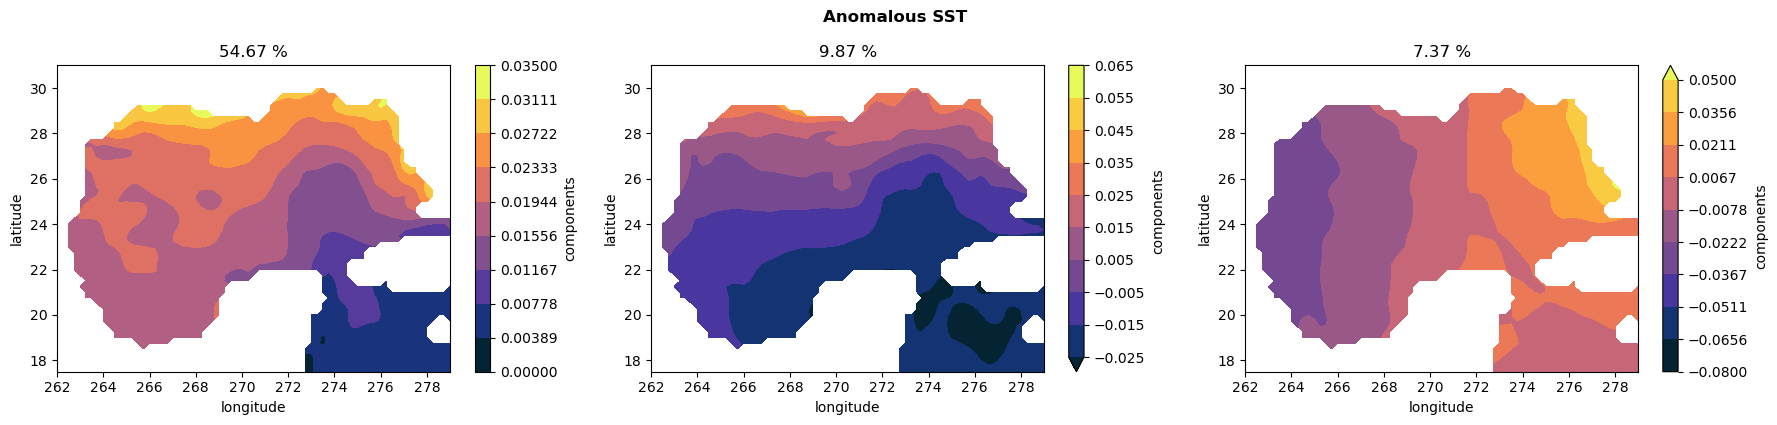

In [8]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.035, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_eof.explained_variance_ratio[0].values*100:.2f} %')

sst_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .065, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_eof.explained_variance_ratio[1].values*100:.2f} %')

sst_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.08, .05, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous SST', fontweight='bold', y=1.05);

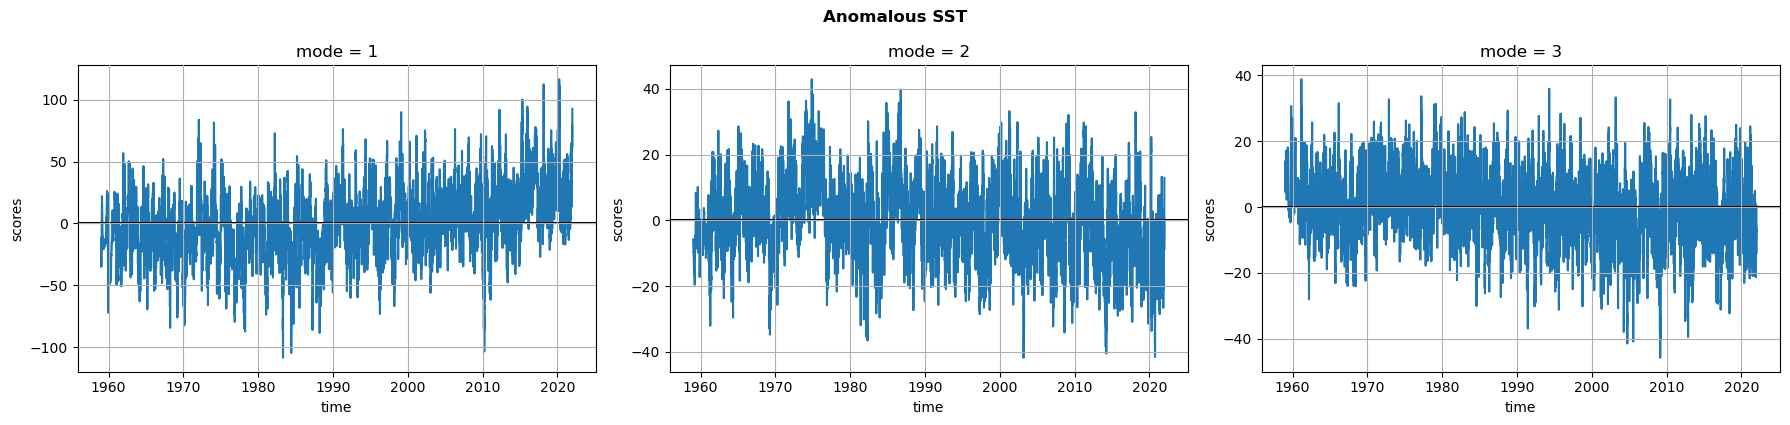

In [9]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sst_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sst_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous SST', fontweight='bold', y=1.05);

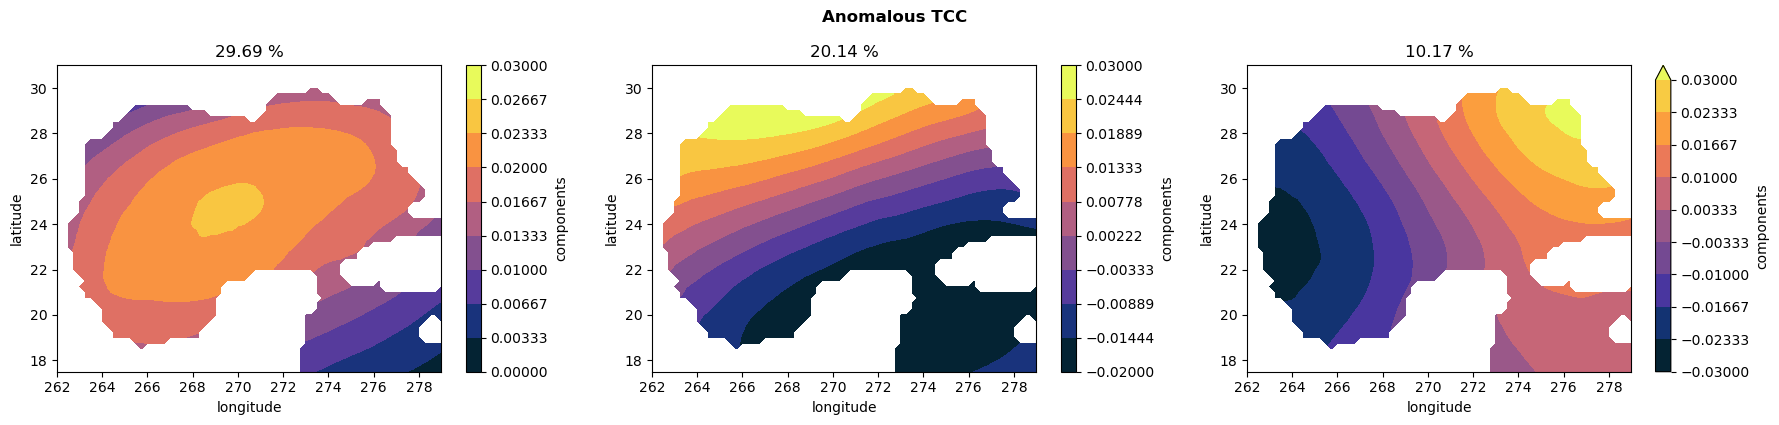

In [10]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

tcc_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{tcc_eof.explained_variance_ratio[0].values*100:.2f} %')

tcc_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.02, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{tcc_eof.explained_variance_ratio[1].values*100:.2f} %')

tcc_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{tcc_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous TCC', fontweight='bold', y=1.05);

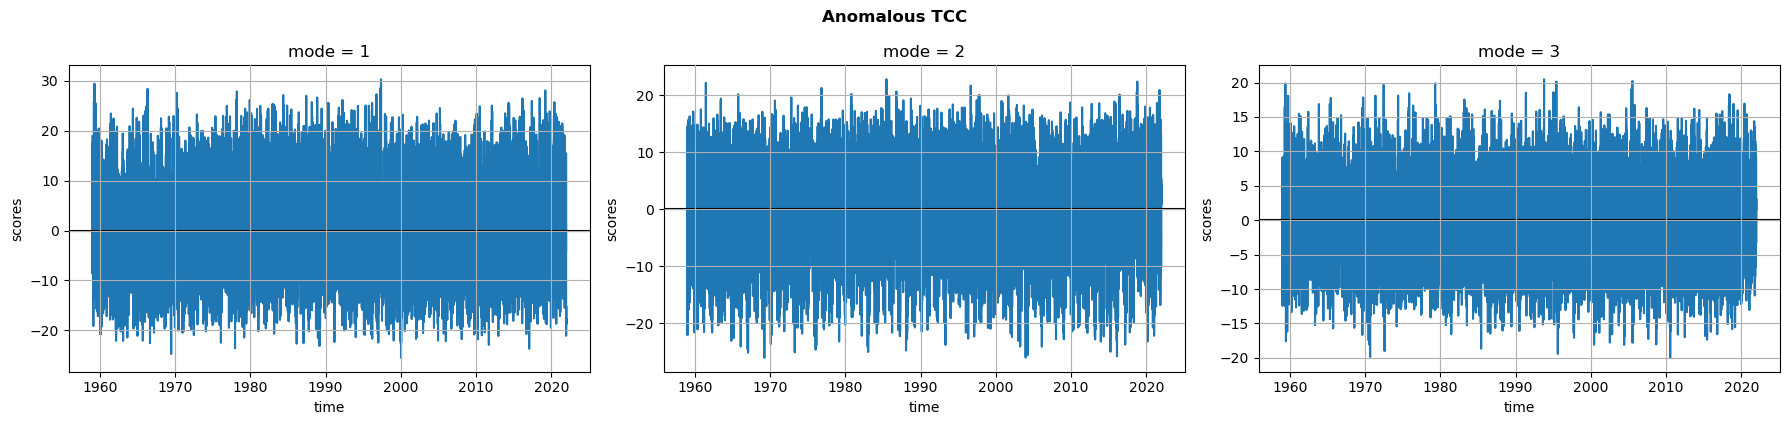

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
tcc_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

tcc_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

tcc_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous TCC', fontweight='bold', y=1.05);

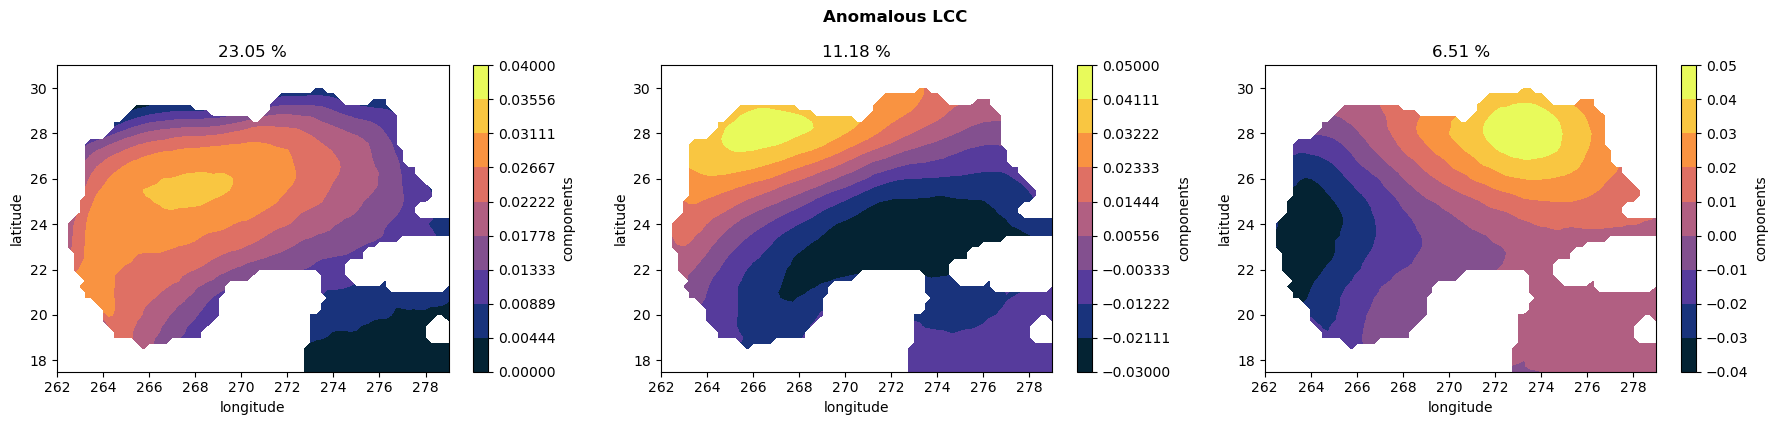

In [12]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

lcc_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, .04, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{lcc_eof.explained_variance_ratio[0].values*100:.2f} %')

lcc_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .05, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{lcc_eof.explained_variance_ratio[1].values*100:.2f} %')

lcc_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .05, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{lcc_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous LCC', fontweight='bold', y=1.05);

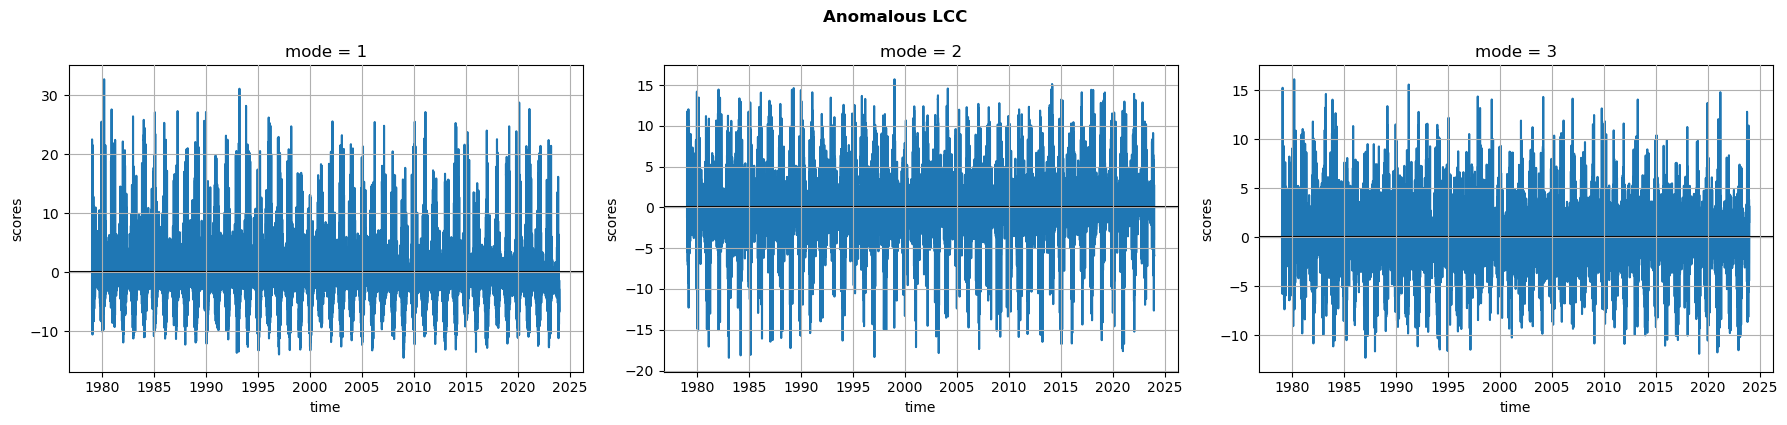

In [13]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lcc_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

lcc_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

lcc_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous LCC', fontweight='bold', y=1.05);

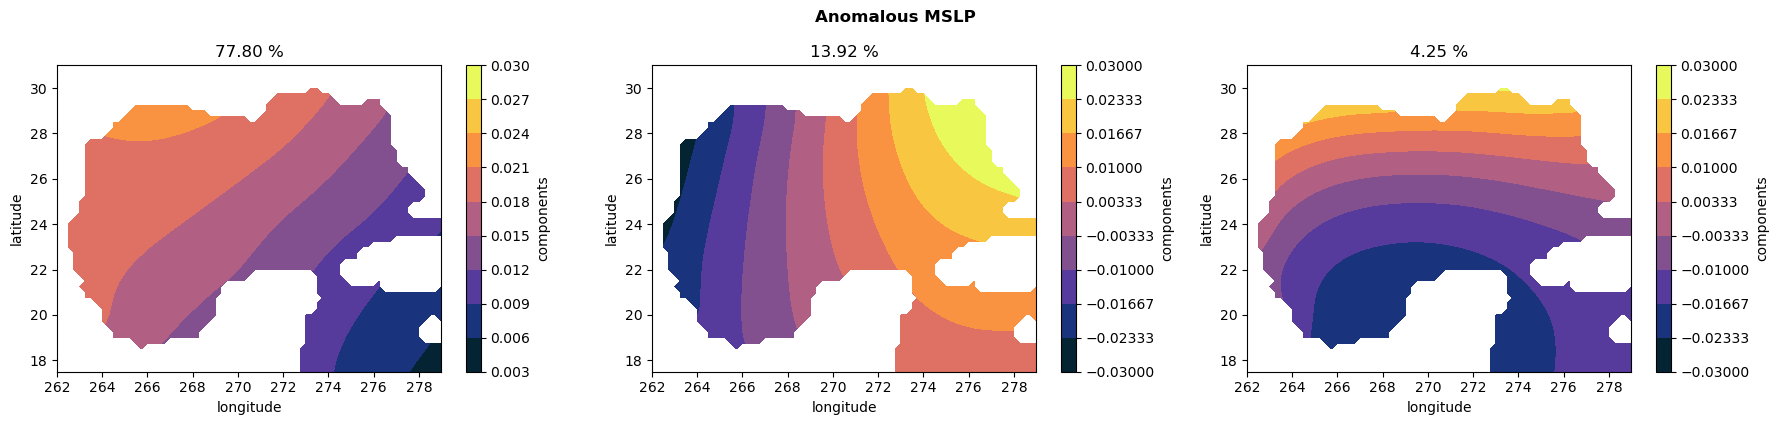

In [14]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

mslp_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.003, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{mslp_eof.explained_variance_ratio[0].values*100:.2f} %')

mslp_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{mslp_eof.explained_variance_ratio[1].values*100:.2f} %')

mslp_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{mslp_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous MSLP', fontweight='bold', y=1.05);

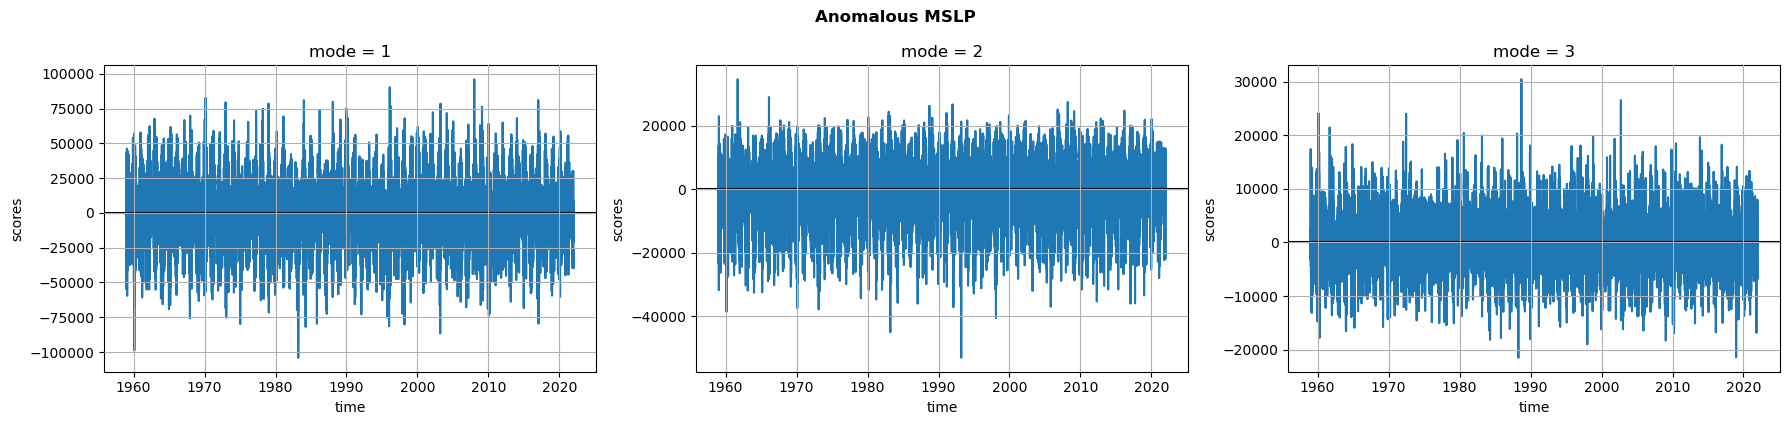

In [15]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
mslp_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

mslp_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

mslp_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous MSLP', fontweight='bold', y=1.05);

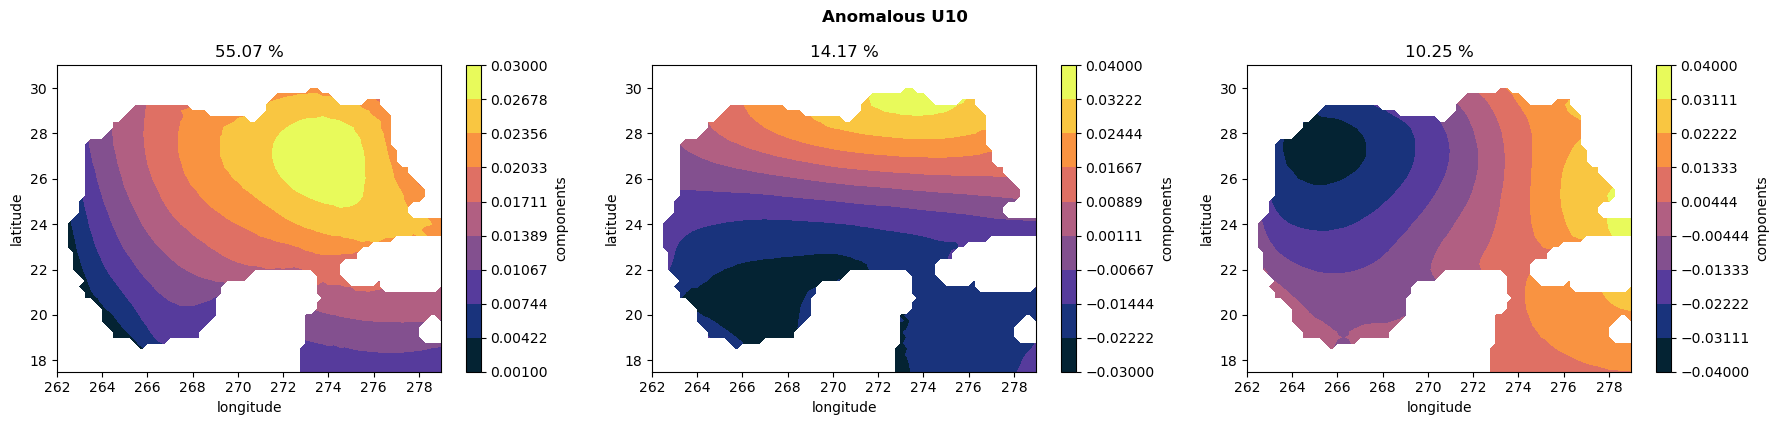

In [16]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.001, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{u10_eof.explained_variance_ratio[0].values*100:.2f} %')
u10_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{u10_eof.explained_variance_ratio[1].values*100:.2f} %')
u10_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{u10_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous U10', fontweight='bold', y=1.05);

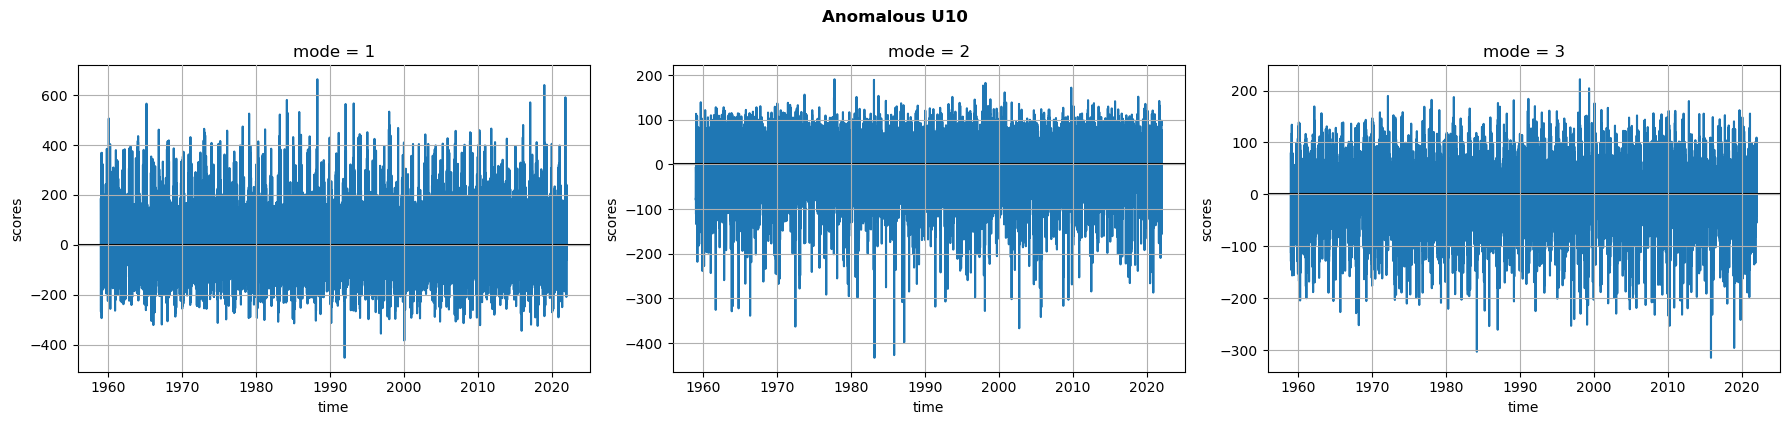

In [17]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

u10_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

u10_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous U10', fontweight='bold', y=1.05);

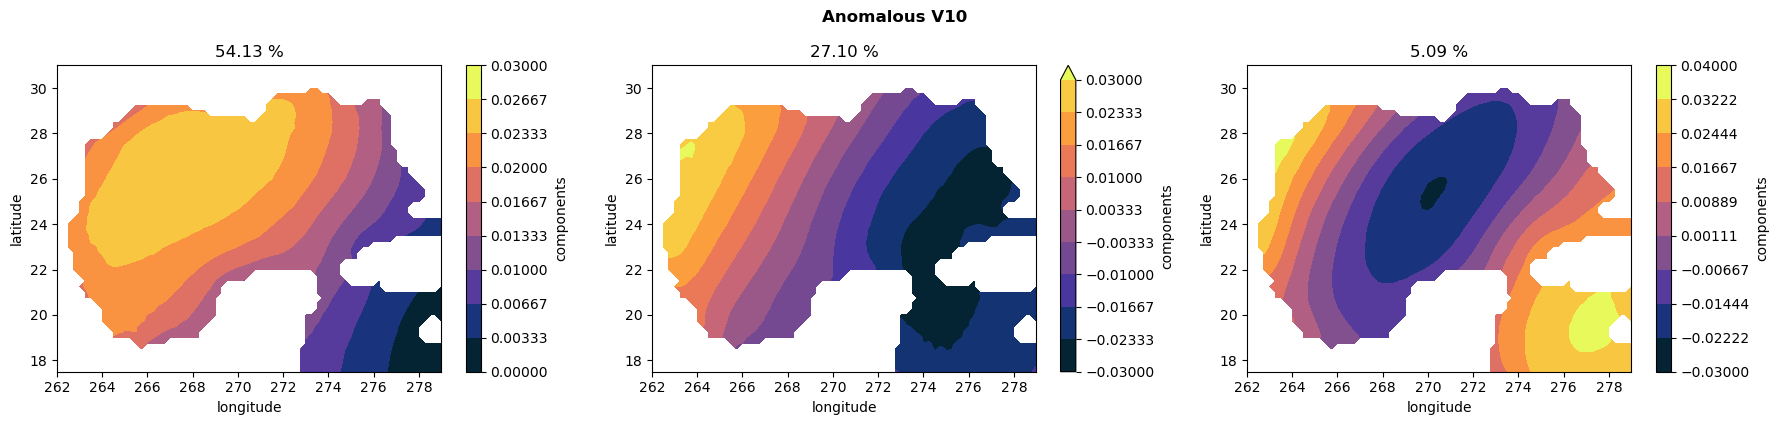

In [18]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_eof.explained_variance_ratio[0].values*100:.2f} %')
v10_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_eof.explained_variance_ratio[1].values*100:.2f} %')
v10_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous V10', fontweight='bold', y=1.05);

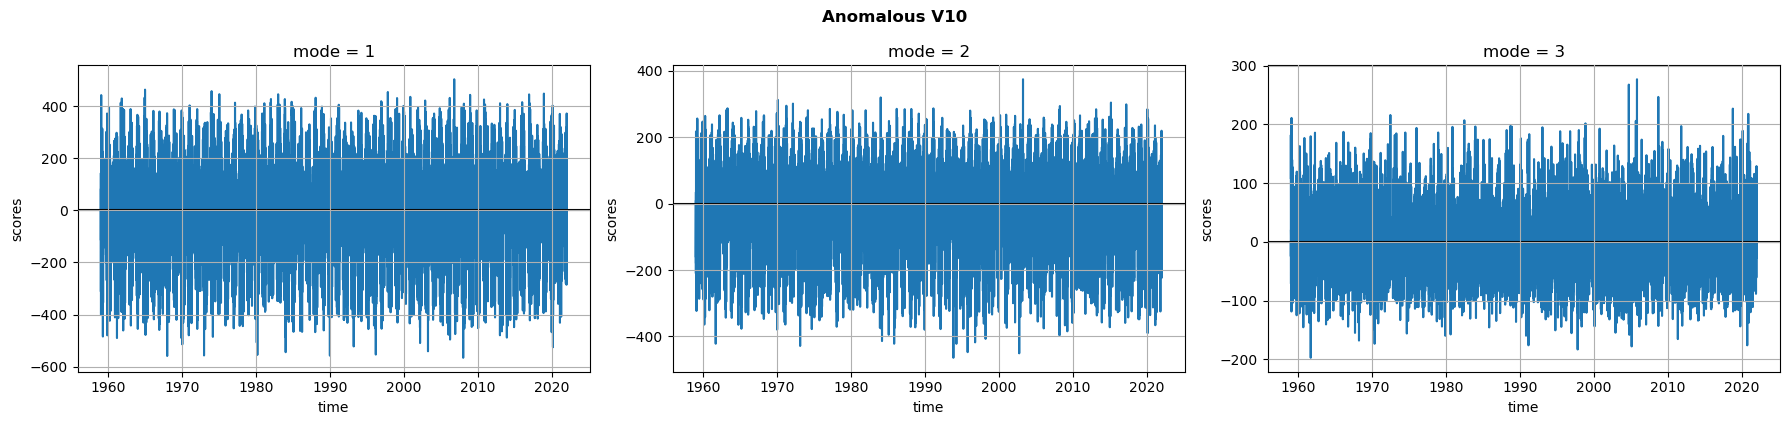

In [19]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

v10_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

v10_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous V10', fontweight='bold', y=1.05);

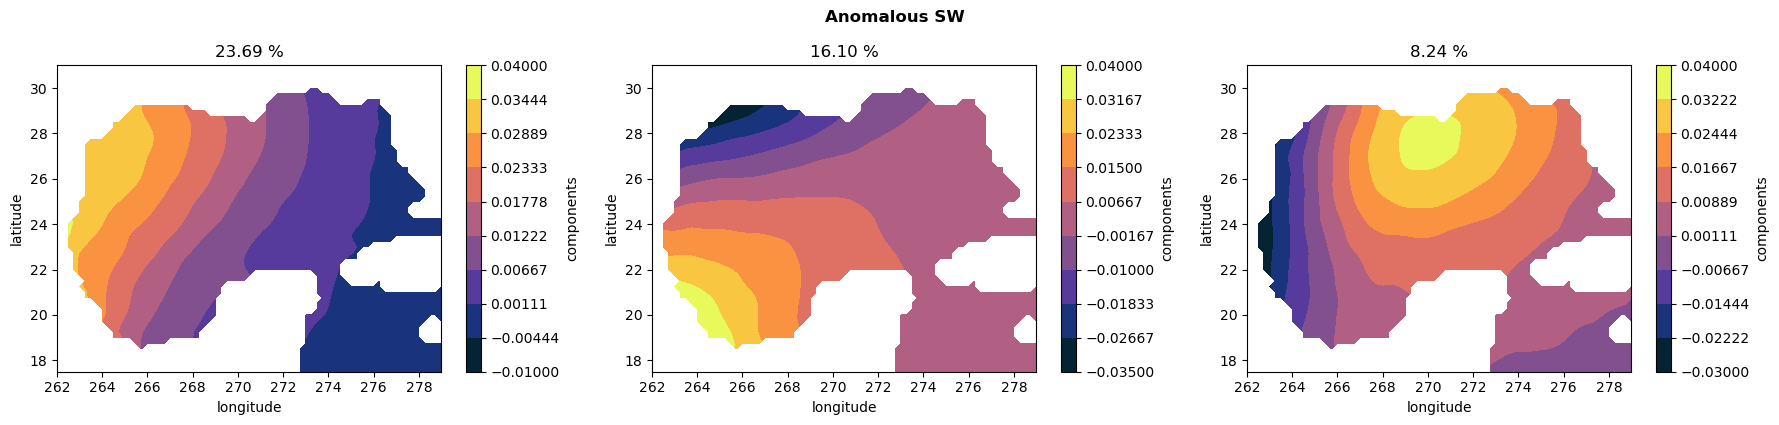

In [20]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sw_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.01, 0.04, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sw_eof.explained_variance_ratio[0].values*100:.2f} %')
sw_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.035, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sw_eof.explained_variance_ratio[1].values*100:.2f} %')
sw_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, 0.04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sw_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous SW', fontweight='bold', y=1.05);

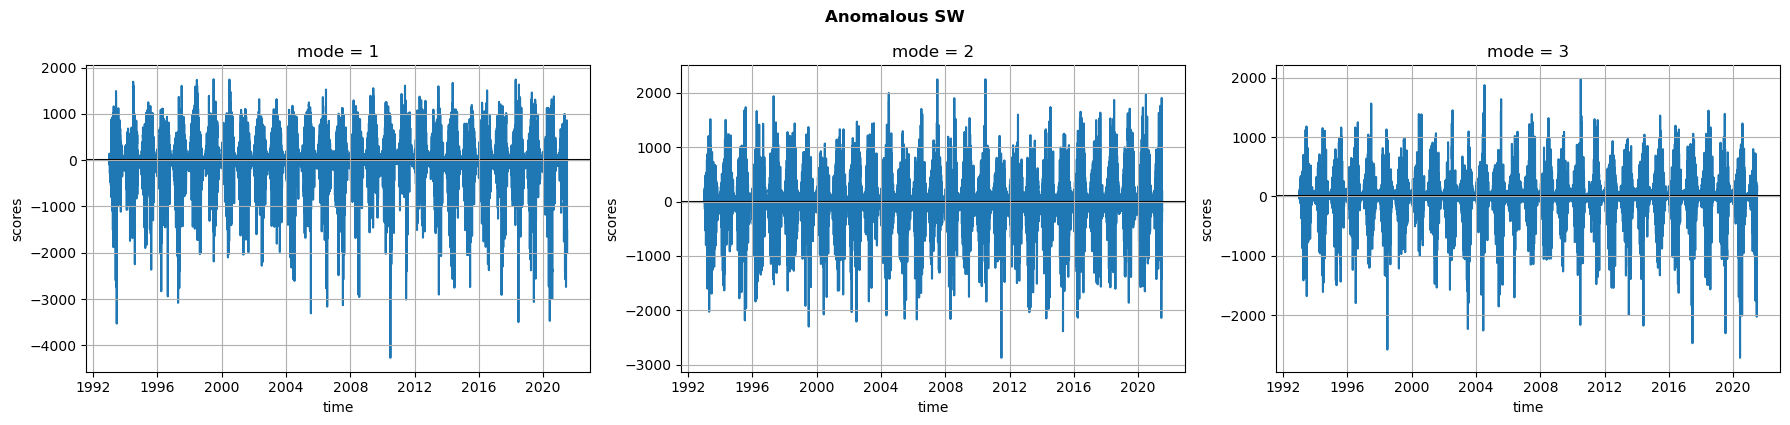

In [21]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sw_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sw_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sw_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous SW', fontweight='bold', y=1.05);

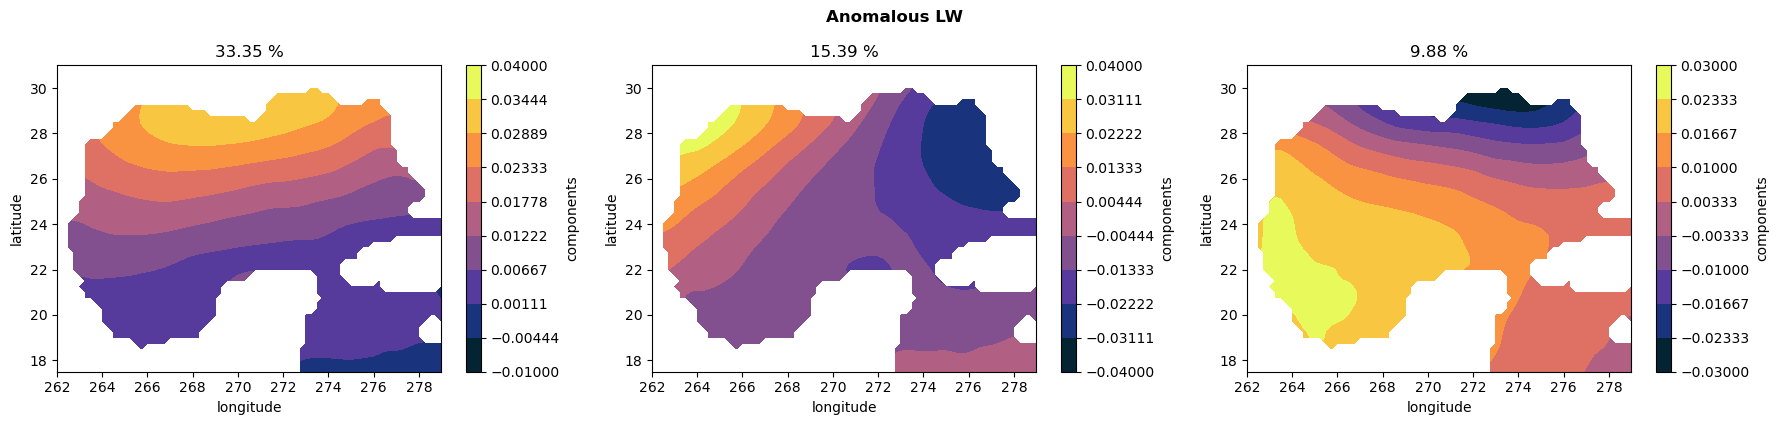

In [54]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lw_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.01, 0.04, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{lw_eof.explained_variance_ratio[0].values*100:.2f} %')
lw_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{lw_eof.explained_variance_ratio[1].values*100:.2f} %')
lw_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{lw_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous LW', fontweight='bold', y=1.05);

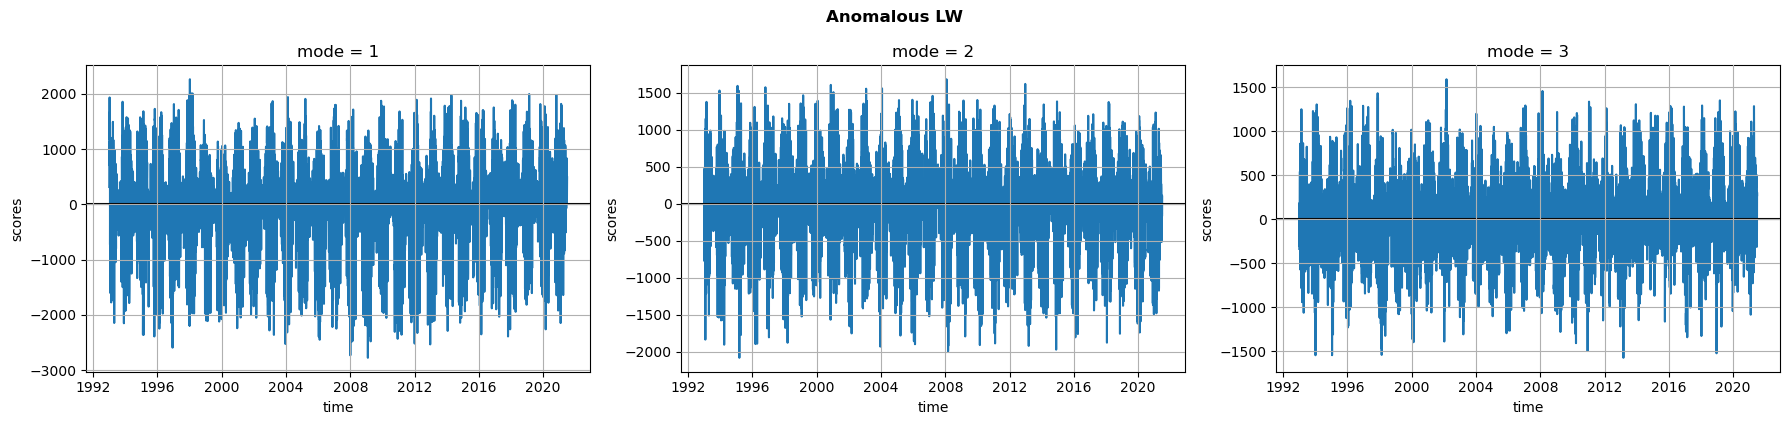

In [22]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lw_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

lw_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

lw_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous LW', fontweight='bold', y=1.05);

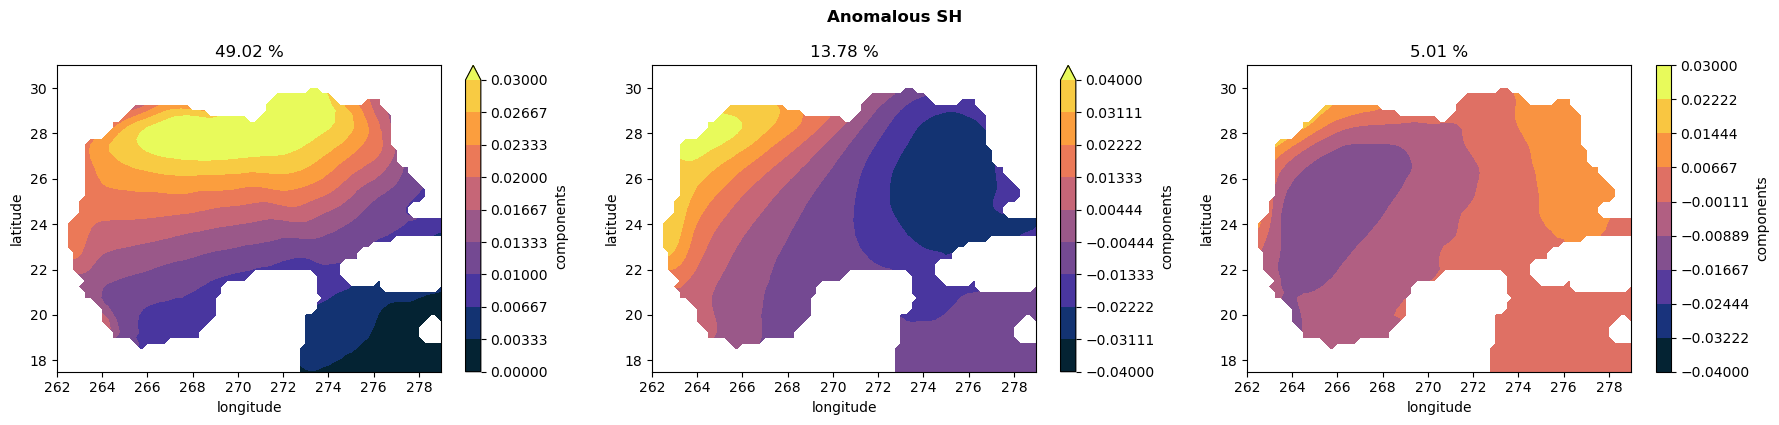

In [25]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sh_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sh_eof.explained_variance_ratio[0].values*100:.2f} %')
sh_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sh_eof.explained_variance_ratio[1].values*100:.2f} %')
sh_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sh_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous SH', fontweight='bold', y=1.05);

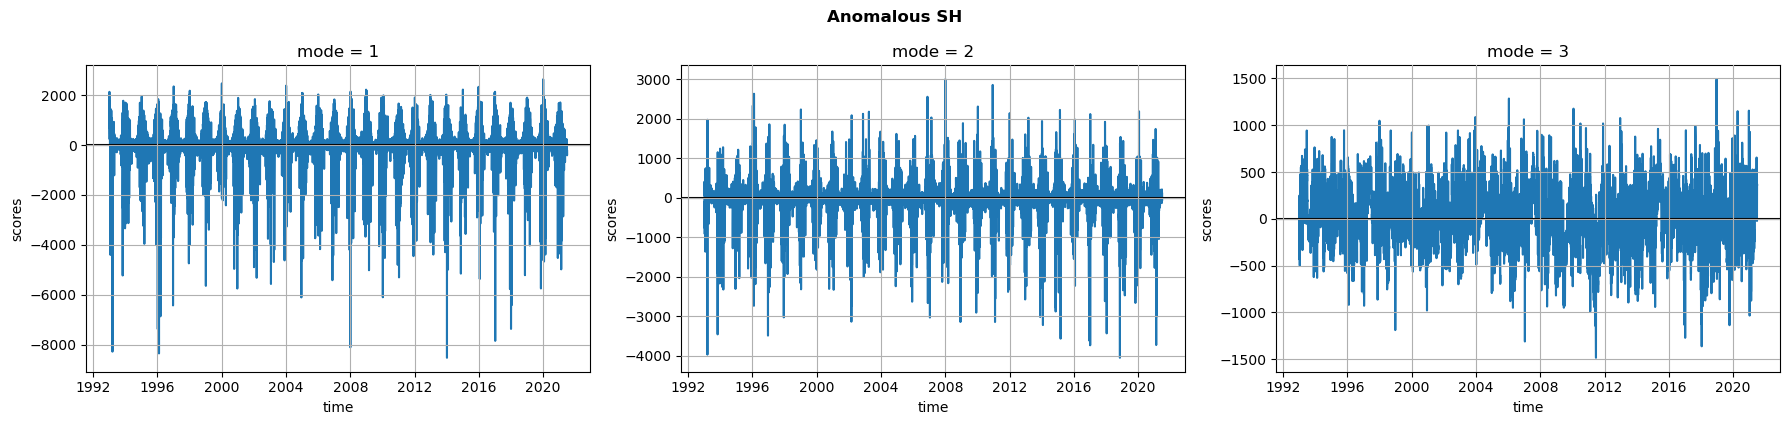

In [26]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sh_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sh_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sh_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous SH', fontweight='bold', y=1.05);

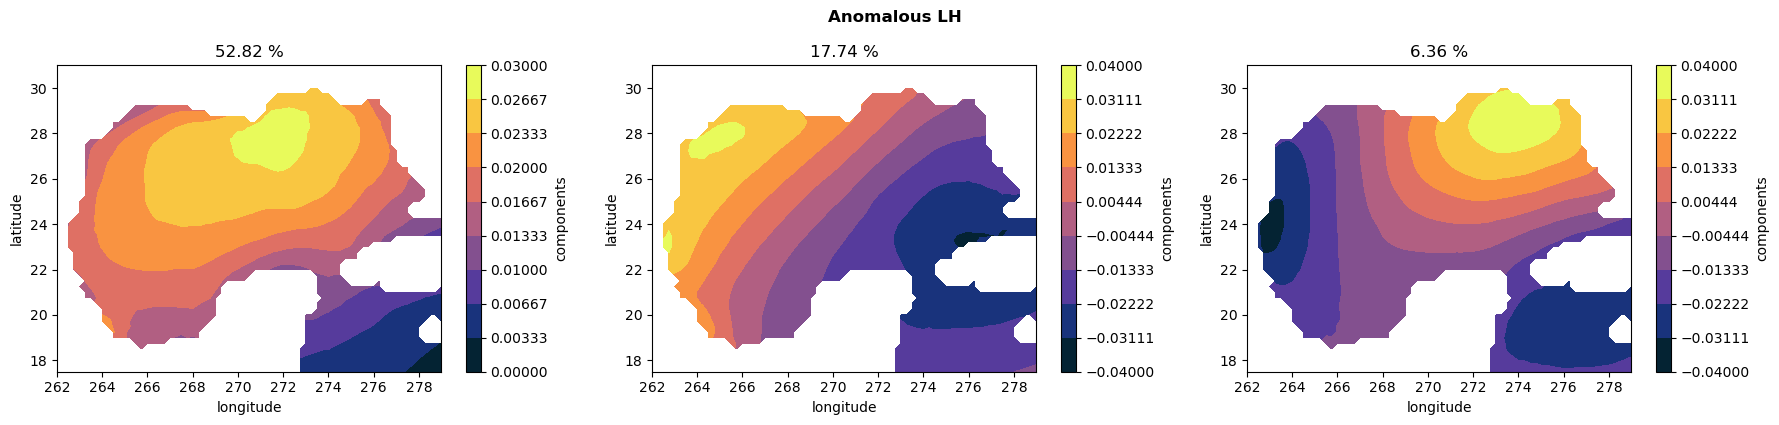

In [27]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lh_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{lh_eof.explained_variance_ratio[0].values*100:.2f} %')
lh_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{lh_eof.explained_variance_ratio[1].values*100:.2f} %')
lh_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{lh_eof.explained_variance_ratio[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('Anomalous LH', fontweight='bold', y=1.05);

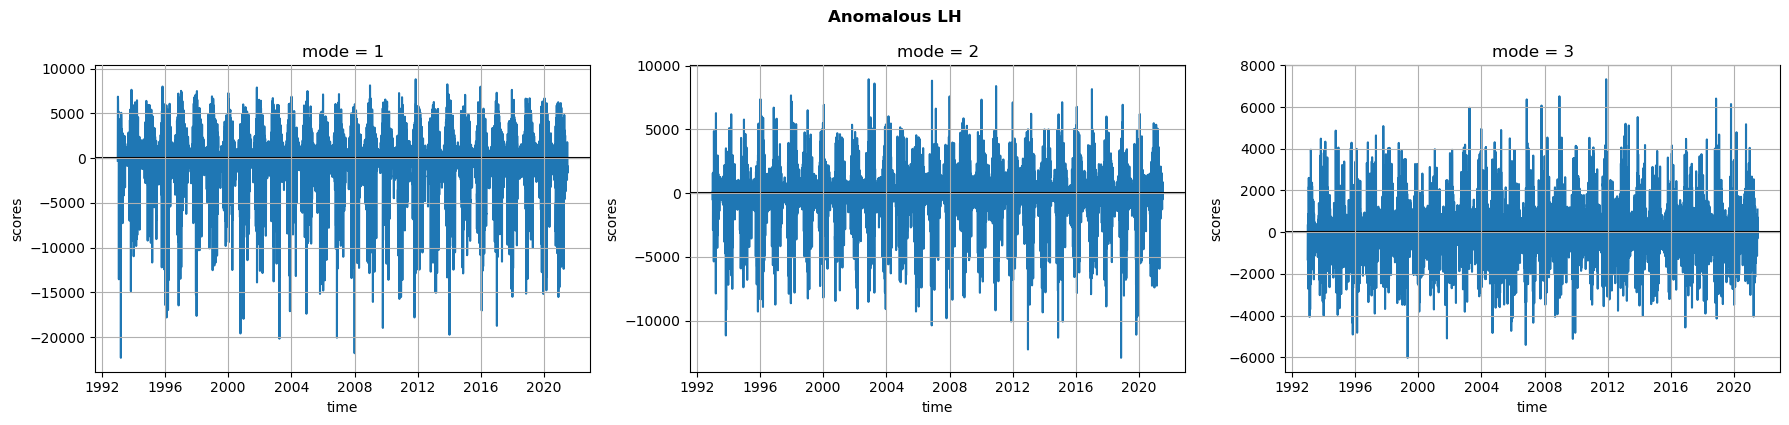

In [29]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lh_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

lh_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

lh_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous LH', fontweight='bold', y=1.05);

### GLORYS vars

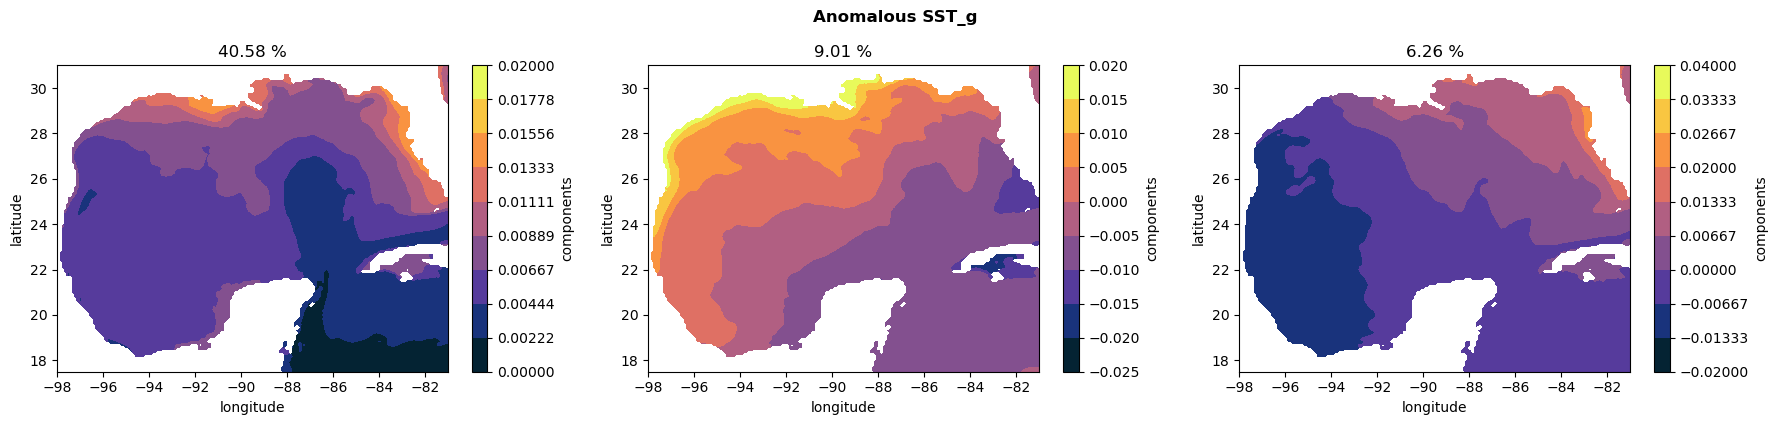

In [34]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_g_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(0, 0.02, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_g_eof.explained_variance_ratio[0].values*100:.2f} %')

sst_g_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .02, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_g_eof.explained_variance_ratio[1].values*100:.2f} %')

sst_g_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.02, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_g_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous SST_g', fontweight='bold', y=1.05);

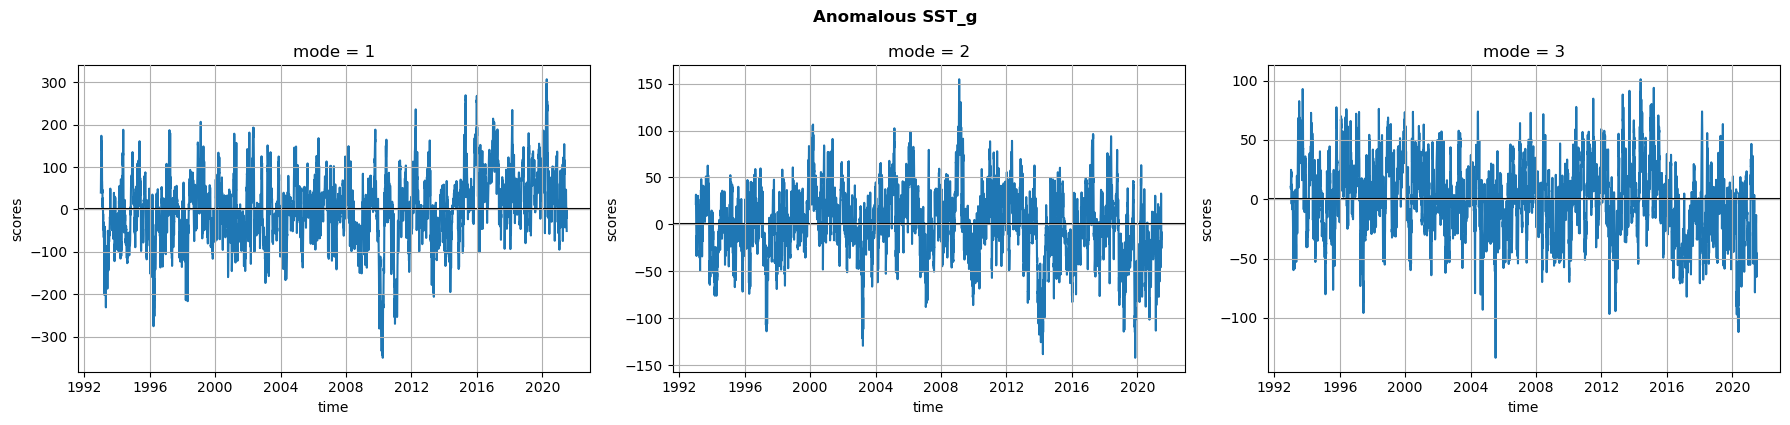

In [35]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_g_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sst_g_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sst_g_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous SST_g', fontweight='bold', y=1.05);

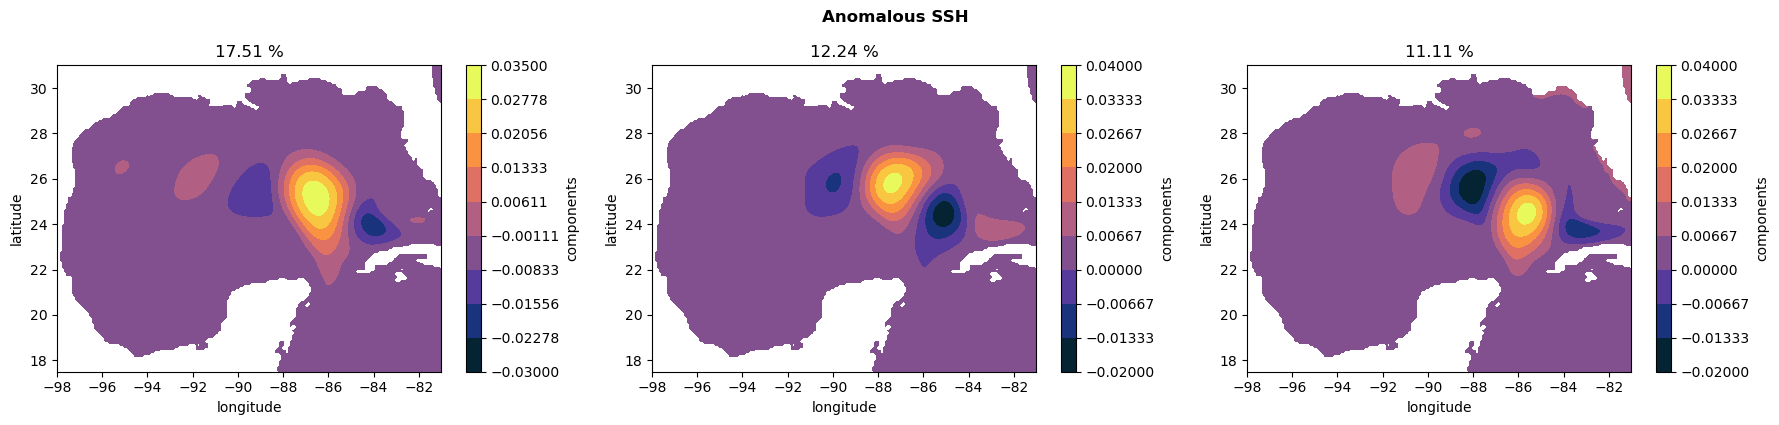

In [39]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ssh_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0.035, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{ssh_eof.explained_variance_ratio[0].values*100:.2f} %')

ssh_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.02, .04, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{ssh_eof.explained_variance_ratio[1].values*100:.2f} %')

ssh_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.02, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{ssh_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous SSH', fontweight='bold', y=1.05);

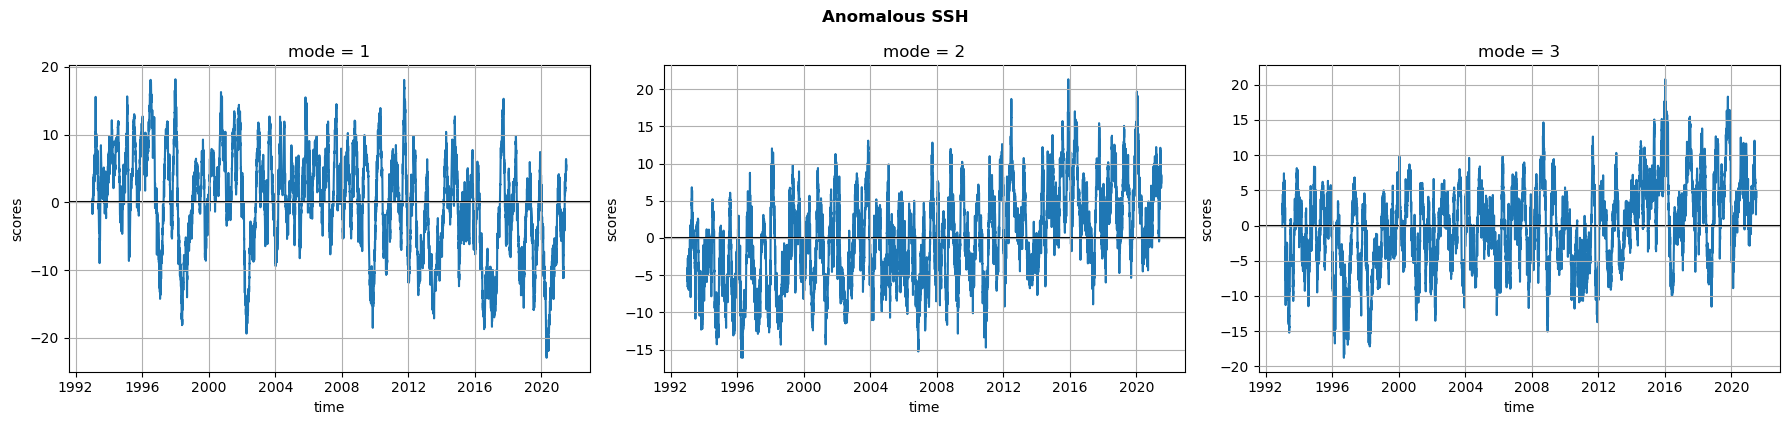

In [40]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ssh_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

ssh_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

ssh_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous SSH', fontweight='bold', y=1.05);

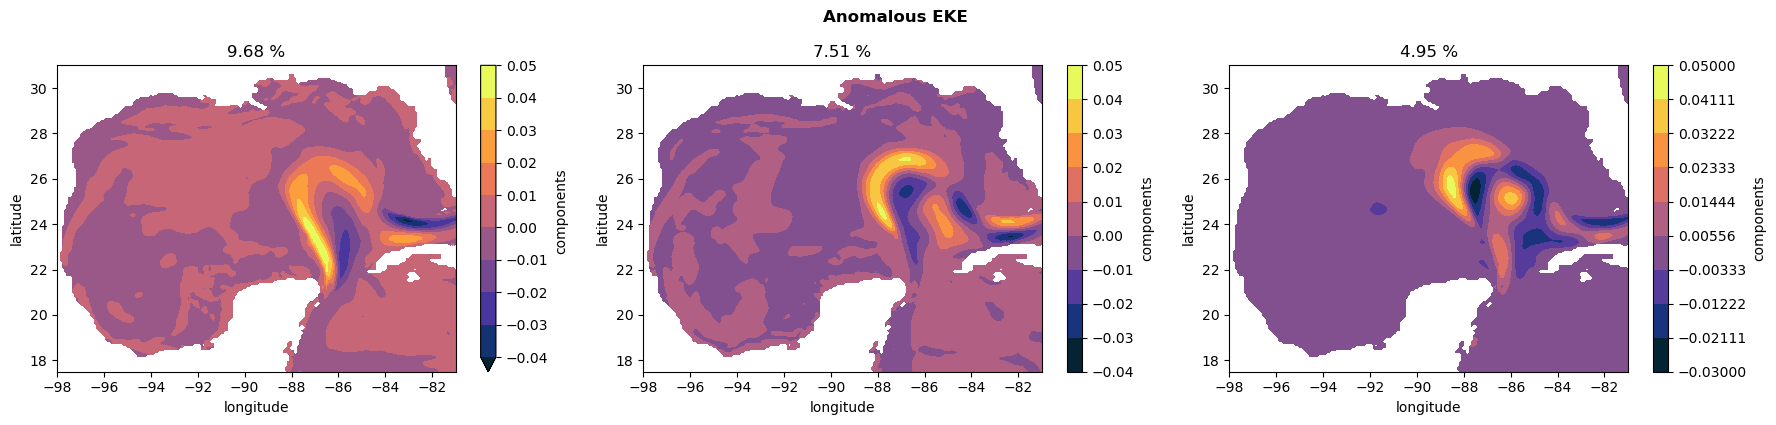

In [42]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
eke_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.04, 0.05, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{eke_eof.explained_variance_ratio[0].values*100:.2f} %')

eke_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.04, .05, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{eke_eof.explained_variance_ratio[1].values*100:.2f} %')

eke_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .05, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{eke_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous EKE', fontweight='bold', y=1.05);

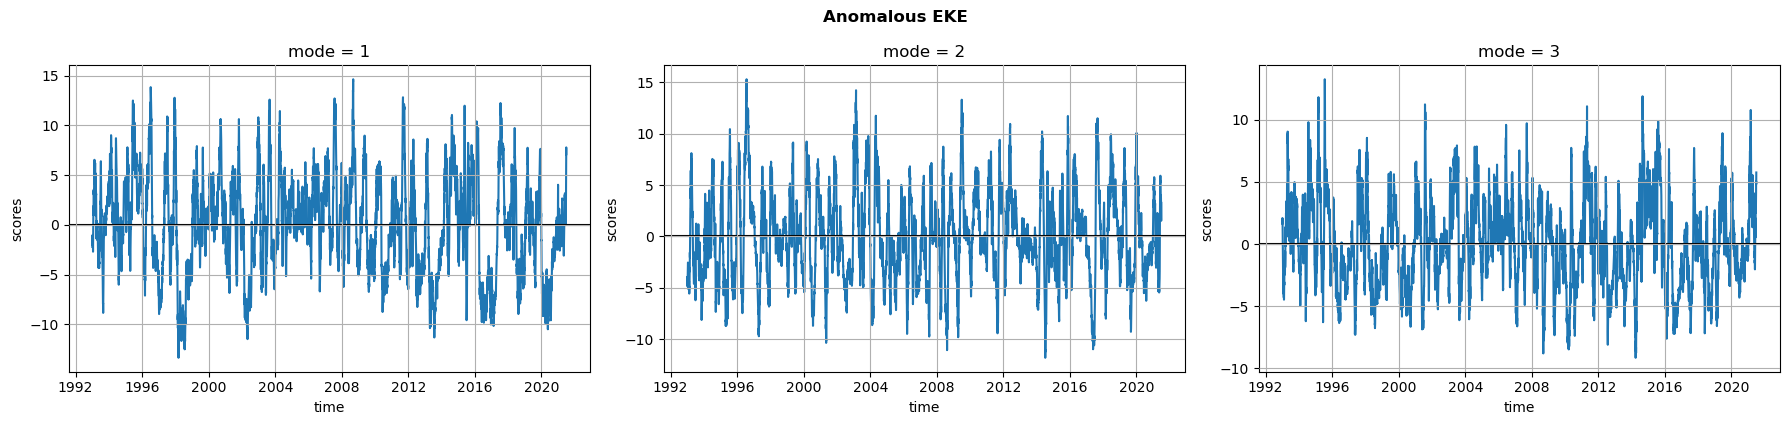

In [43]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
eke_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

eke_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

eke_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous EKE', fontweight='bold', y=1.05);

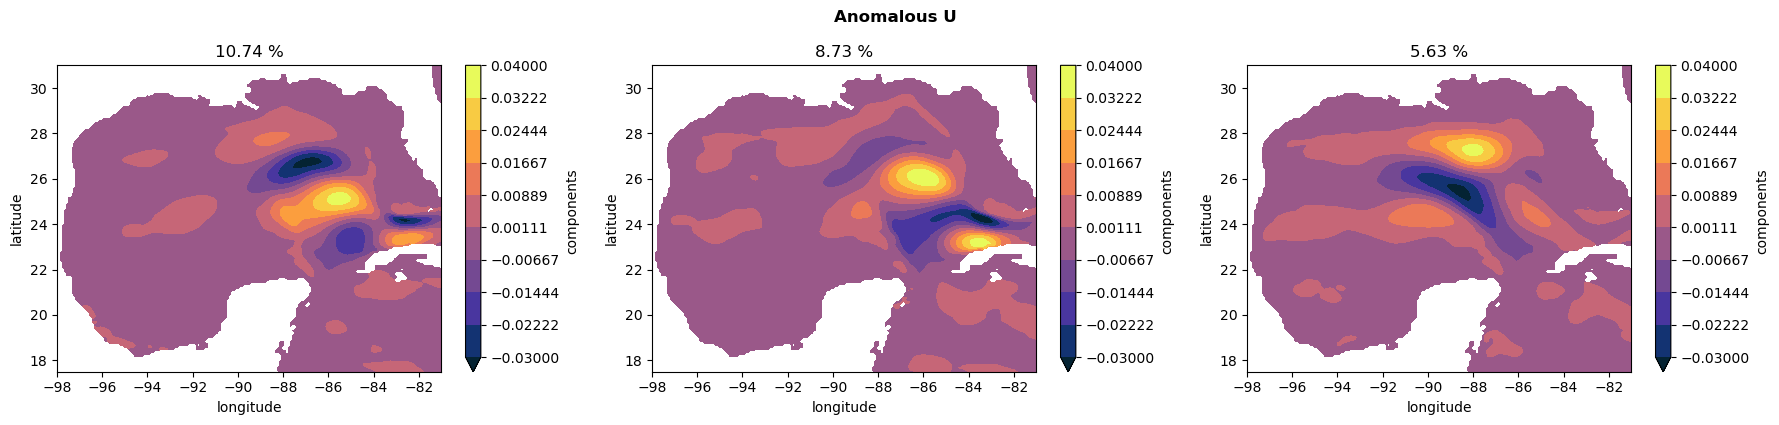

In [50]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0.04, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{u_eof.explained_variance_ratio[0].values*100:.2f} %')

u_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{u_eof.explained_variance_ratio[1].values*100:.2f} %')

u_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{u_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous U', fontweight='bold', y=1.05);

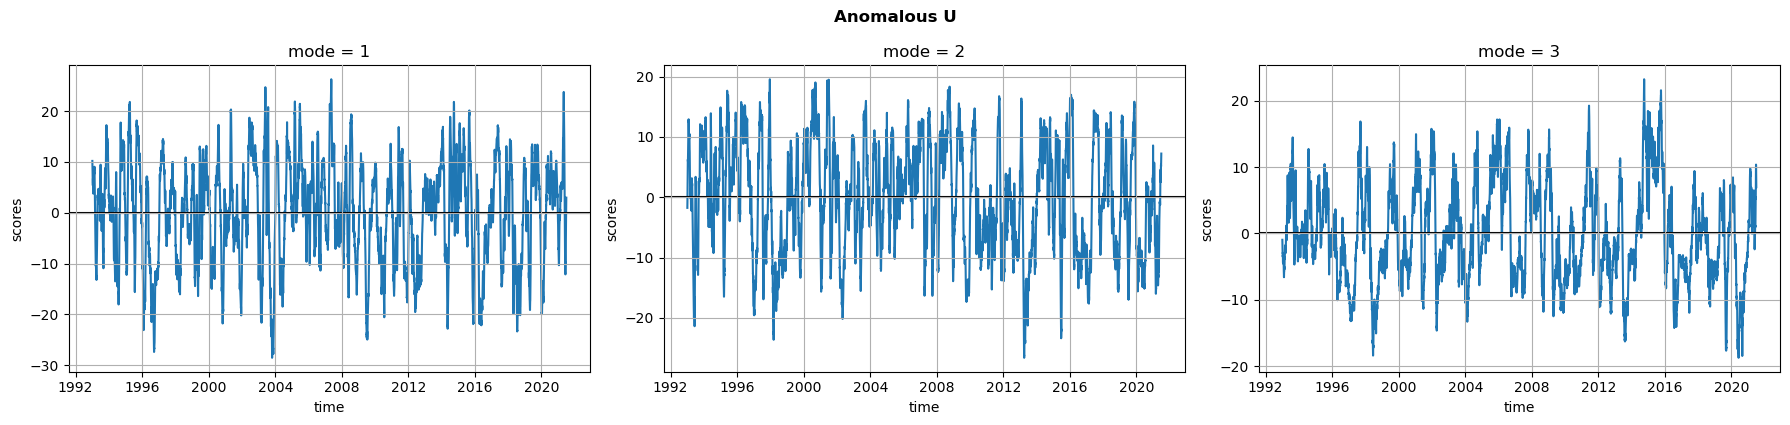

In [45]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

u_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

u_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous U', fontweight='bold', y=1.05);

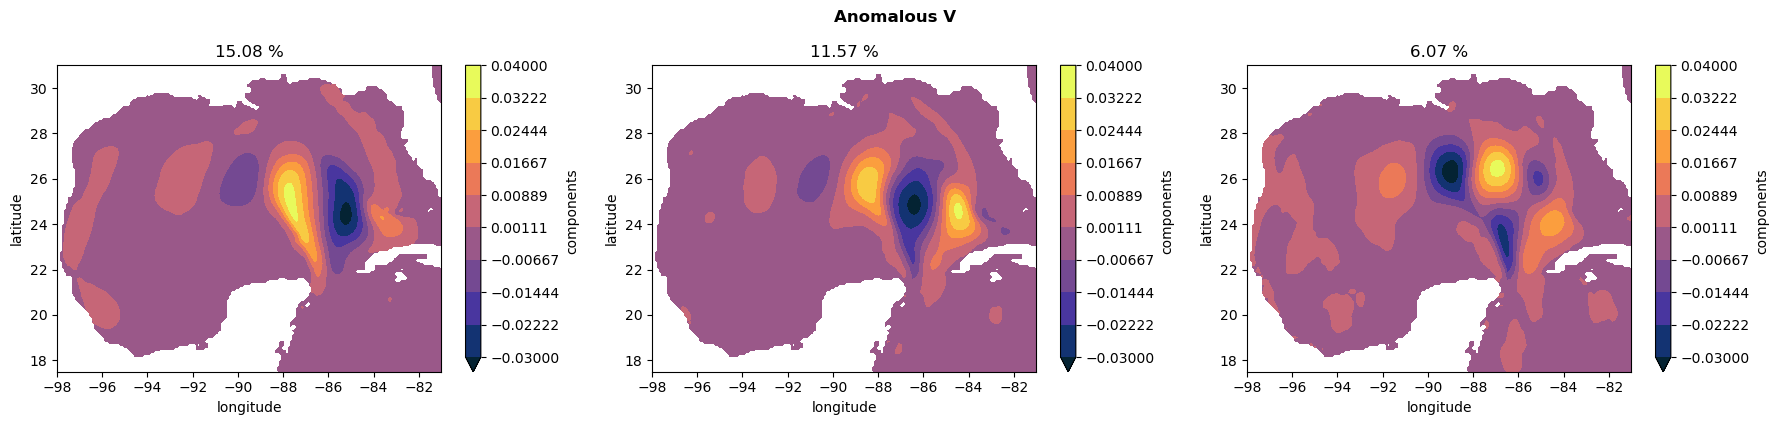

In [53]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v_eof.components[0].plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0.04, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v_eof.explained_variance_ratio[0].values*100:.2f} %')

v_eof.components[1].plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v_eof.explained_variance_ratio[1].values*100:.2f} %')

v_eof.components[2].plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v_eof.explained_variance_ratio[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('Anomalous V', fontweight='bold', y=1.05);

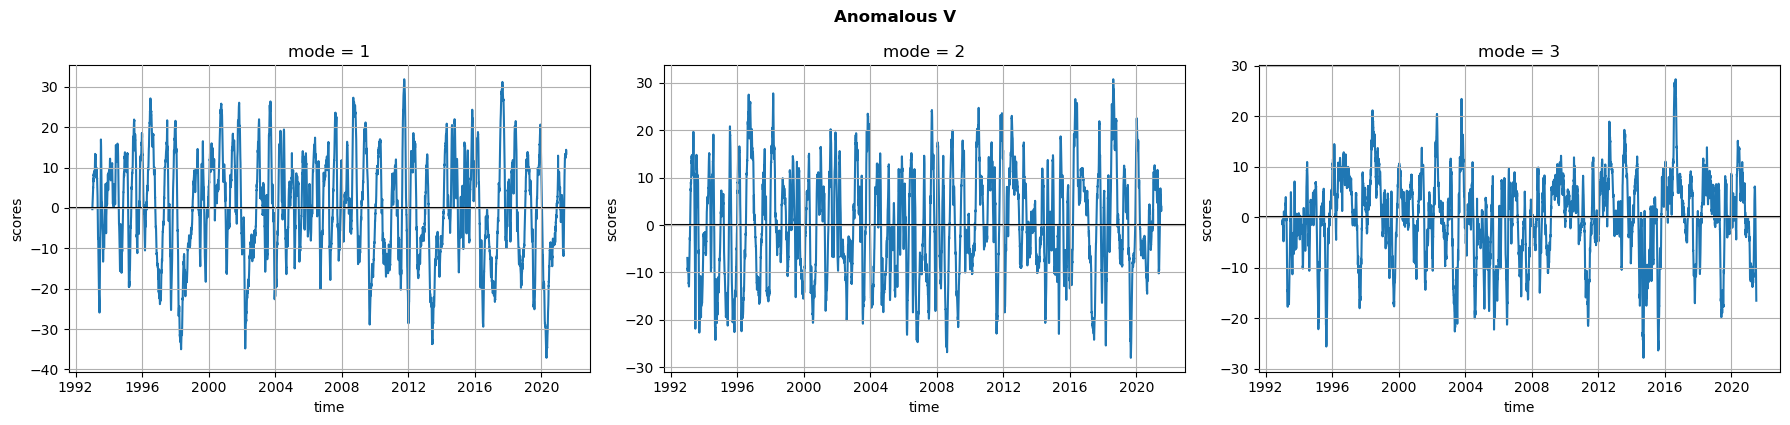

In [52]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v_eof.scores.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

v_eof.scores.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

v_eof.scores.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('Anomalous V', fontweight='bold', y=1.05);